# 5G Copper classification tasks 
1. Prepare expression data for pre-made splits (to use in other warm-start modeling runs)
2. Try a preliminary set of cold start models specifically for the copper tasks of interest:
  * Cu classification (Up, Down, No change)
  * Cu TPM regression (Log TPM of HighCu)

In [1]:
import torch
from torch import nn

import altair as alt
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import scipy
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report

import time


import models as m
import utils as u
import torch_utils as tu
from torch_utils import DatasetSpec
import viz as v

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

## 1. Prepare 5G expression data for splits
Load 5G log ratio:NoCopper data

In [4]:
locus_info_filename = 'data/locus2info_20221031.tsv'
locus_info_df = pd.read_csv(locus_info_filename,sep='\t')
locus2info = u.make_info_dict(locus_info_df)

#data_filename = "data/XY_logTPM_opFilt_20221031.tsv"
data_filename = "data/XY_lr_noCu_opFilt_20221031.tsv"
XYdf_og = pd.read_csv(data_filename,sep='\t')
XYdf_og['gene'] = XYdf_og['locus_tag'].apply(lambda x: locus2info[x]['gene'])
XYdf_og['product'] = XYdf_og['locus_tag'].apply(lambda x: locus2info[x]['product'])
XYdf_og['type'] = XYdf_og['locus_tag'].apply(lambda x: locus2info[x]['type'])

XYdf_og

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,...,WithLanthanum,NoLanthanum,LanzaTech,aa3_KO,crotonic_acid,CH4_500ppm,CH4_1000ppm,gene,product,type
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,0.333441,-0.087509,-0.248330,-0.654293,0.0,0.252788,0.260753,...,-0.117634,-0.180709,-0.516711,-0.472602,0.058102,0.668619,0.215153,dnaA,chromosomal replication initiator protein DnaA,CDS
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,0.179318,-0.183682,-0.493245,-1.323530,0.0,0.418315,0.611021,...,-0.244793,-0.161434,0.237179,-0.079076,0.132689,-0.462317,-0.490073,dnaN,DNA polymerase III subunit beta,CDS
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,0.364849,0.170159,-0.338861,-0.347147,0.0,0.287824,0.387577,...,-0.249011,-0.066333,-0.987336,-0.990306,0.481623,0.144467,-0.239513,recF,DNA replication/repair protein RecF,CDS
3,4,EQU24_RS00035,GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...,0.193539,0.035923,0.136026,-0.642058,0.0,0.189394,0.345084,...,0.643283,0.566397,-0.952383,-0.465515,0.009531,0.367039,0.695145,NaN,hypothetical protein,CDS
4,9,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,0.173256,0.283822,-0.740565,-1.011908,0.0,0.215938,0.306791,...,0.539188,0.622656,-0.716034,-0.025042,0.070784,-0.367242,-0.319915,NaN,bifunctional diguanylate cyclase/phosphodieste...,CDS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,4182,EQU24_RS23145,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,0.620221,0.718300,0.245892,-1.598809,0.0,0.171579,0.501296,...,0.977712,1.564370,0.701928,1.577361,0.777911,0.463434,0.727701,hxlA,3-hexulose-6-phosphate synthase,CDS
2207,4184,EQU24_RS23155,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,0.609995,0.702416,0.231606,-1.614646,0.0,0.154029,0.483579,...,0.952955,1.548383,0.701457,1.573150,0.761210,0.433925,0.705205,hxlA,3-hexulose-6-phosphate synthase,CDS
2208,4186,EQU24_RS23165,TTGAAACCCTAAGGTACATTGAGGCGTTAGCAAAGAGCAAGTTTGA...,0.605448,0.688065,0.233752,-1.594922,0.0,0.171939,0.486032,...,0.899683,1.442487,0.708730,1.520411,0.769644,0.032260,0.305817,hxlA,3-hexulose-6-phosphate synthase,CDS
2209,4187,EQU24_RS23170,AATCTTCATTAGAGTCGAACGAAGTTTCATGTTTTCGGCTTCCTCA...,0.604488,0.196871,-0.261330,0.125607,0.0,-0.014653,0.229101,...,-0.233161,0.107133,0.265191,-0.870372,0.814080,-0.245552,-0.285502,NaN,transposase,CDS


In [5]:
tu.set_reg_class_up_down(XYdf_og,'highCu',thresh=0.6)
XYdf_og['highCu_reg_UD'].value_counts()

1    1957
2     159
0      95
Name: highCu_reg_UD, dtype: int64

In [6]:
# get TPM df to filter out non-expressing genes
data_filename = "data/XY_TPM_opFilt_20221031.tsv"
tpm_df = pd.read_csv(data_filename,sep='\t')
tpm_df

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,lowCu,highO2_slow_growth,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum,LanzaTech,aa3_KO,crotonic_acid,CH4_500ppm,CH4_1000ppm
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,44.589239,33.305149,29.791989,22.484978,35.387855,42.164887,42.398329,36.574762,62.642333,30.485060,32.616911,31.221609,24.734827,25.502734,36.842130,56.250801,41.079168
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,51.646261,40.157361,32.402422,18.223699,45.609876,60.951472,69.661793,51.522053,95.745624,41.526462,38.491860,40.781423,53.759707,43.177206,50.003709,33.104545,32.473733
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,29.102185,25.428342,17.868485,17.766155,22.599309,27.589182,29.564291,24.013022,43.385614,20.311406,19.016705,21.583752,11.399278,11.375836,31.555718,24.979519,19.142317
3,4,EQU24_RS00035,GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...,75.378027,67.576797,72.432184,42.238158,65.914934,75.161805,83.726814,67.429437,94.526584,55.016260,102.951158,97.608173,34.063390,47.736427,66.351841,85.010678,106.719351
4,9,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,23.475112,25.344937,12.460055,10.323755,20.818638,24.179988,25.751687,21.777752,18.879559,21.903063,30.252690,32.054614,12.673738,20.460387,21.865558,16.139920,16.678171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,4182,EQU24_RS23145,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,2414.351803,2584.195759,1862.586567,518.568549,1570.708136,1769.073837,2223.313532,1579.606430,1204.757230,4261.953435,3093.257534,4645.343725,2555.034515,4687.360578,2693.209622,2165.722951,2601.090142
2207,4184,EQU24_RS23155,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,2419.134023,2579.178379,1861.029495,517.578238,1585.013725,1763.601177,2216.179330,1578.753812,1222.646543,4246.905233,3068.323264,4635.992387,2577.463359,4716.267599,2686.458439,2141.201715,2584.168594
2208,4186,EQU24_RS23165,TTGAAACCCTAAGGTACATTGAGGCGTTAGCAAAGAGCAAGTTTGA...,2427.383179,2570.446233,1876.060099,528.154680,1595.439950,1797.376818,2234.552551,1612.522000,1275.901815,4230.257160,2976.542208,4336.229765,2607.531550,4576.881691,2719.984378,1631.517103,1972.152368
2209,4187,EQU24_RS23170,AATCTTCATTAGAGTCGAACGAAGTTTCATGTTTTCGGCTTCCTCA...,51.530064,38.846844,28.276361,36.974559,33.891568,33.549091,39.724451,29.848200,37.808647,28.096495,28.833893,36.504131,40.730731,18.538883,59.587377,28.587290,27.806550


In [7]:
# load conditions of interest
with open("data/conditions_to_include_20221031.txt",'r') as f:
    conds = [x.strip() for x in f.readlines()]
    
conds

['uMax',
 'lowO2_fast_growth',
 'lowCH4',
 'MeOH',
 'NoCu',
 'medCu',
 'highCu',
 'lowCu',
 'highO2_slow_growth',
 'NO3_lowO2_slow_growth',
 'WithLanthanum',
 'NoLanthanum',
 'LanzaTech',
 'aa3_KO',
 'crotonic_acid',
 'CH4_500ppm',
 'CH4_1000ppm']

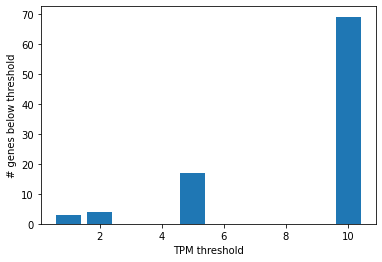

In [8]:
# Get gene ids the never express above a given TPM threshold

no_tx_genes1 = []
no_tx_genes2 = []
no_tx_genes5 = []
no_tx_genes10 = []

# collect genes in each threshold
for i, row, in tpm_df.iterrows():
    tpms = row[conds].values
    if max(tpms) < 1.0:
        no_tx_genes1.append(row['locus_tag'])
    if max(tpms) < 2.0:
        no_tx_genes2.append(row['locus_tag'])
    if max(tpms) < 5.0:
        no_tx_genes5.append(row['locus_tag'])
    if max(tpms) < 10.0:
        no_tx_genes10.append(row['locus_tag'])

# Plot gene counts at each threshold
plt.bar([1,2,5,10],[len(no_tx_genes1),len(no_tx_genes2),len(no_tx_genes5),len(no_tx_genes10)])
plt.xlabel("TPM threshold")
plt.ylabel("# genes below threshold")
plt.show()

In [9]:
# There are some lowly expressing genes (never expression above 5TPM)
# that end up in the Up and Down groups... let's remove all these
XYdf_og[XYdf_og['locus_tag'].isin(no_tx_genes5)].sort_values('highCu')[['locus_tag','product','highCu','highCu_reg_UD']]

,locus_tag,product,highCu,highCu_reg_UD
1072,EQU24_RS11380,IS66 family transposase,-2.110366,0
861,EQU24_RS09050,IS66 family transposase,-2.010145,0
1559,EQU24_RS16370,helix-turn-helix domain-containing protein,-0.668370,0
1871,EQU24_RS19655,IS66 family transposase,-0.595065,1
2195,EQU24_RS23040,hypothetical protein,-0.486623,1
116,EQU24_RS01215,IS66 family transposase,-0.459513,1
2138,EQU24_RS22355,hypothetical protein,-0.453829,1
719,EQU24_RS07485,IS66 family transposase,0.000000,1
2191,EQU24_RS23000,hypothetical protein,0.000000,1
1959,EQU24_RS20685,AAA family ATPase,0.039976,1


#### `XYdf` is filtered for genes that express above 5TPM in at least 1 condition

In [10]:
XYdf = XYdf_og[~XYdf_og['locus_tag'].isin(no_tx_genes5)].reset_index().drop('index',axis=1)
XYdf

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,...,NoLanthanum,LanzaTech,aa3_KO,crotonic_acid,CH4_500ppm,CH4_1000ppm,gene,product,type,highCu_reg_UD
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,0.333441,-0.087509,-0.248330,-0.654293,0.0,0.252788,0.260753,...,-0.180709,-0.516711,-0.472602,0.058102,0.668619,0.215153,dnaA,chromosomal replication initiator protein DnaA,CDS,1
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,0.179318,-0.183682,-0.493245,-1.323530,0.0,0.418315,0.611021,...,-0.161434,0.237179,-0.079076,0.132689,-0.462317,-0.490073,dnaN,DNA polymerase III subunit beta,CDS,2
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,0.364849,0.170159,-0.338861,-0.347147,0.0,0.287824,0.387577,...,-0.066333,-0.987336,-0.990306,0.481623,0.144467,-0.239513,recF,DNA replication/repair protein RecF,CDS,1
3,4,EQU24_RS00035,GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...,0.193539,0.035923,0.136026,-0.642058,0.0,0.189394,0.345084,...,0.566397,-0.952383,-0.465515,0.009531,0.367039,0.695145,NaN,hypothetical protein,CDS,1
4,9,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,0.173256,0.283822,-0.740565,-1.011908,0.0,0.215938,0.306791,...,0.622656,-0.716034,-0.025042,0.070784,-0.367242,-0.319915,NaN,bifunctional diguanylate cyclase/phosphodieste...,CDS,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2189,4182,EQU24_RS23145,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,0.620221,0.718300,0.245892,-1.598809,0.0,0.171579,0.501296,...,1.564370,0.701928,1.577361,0.777911,0.463434,0.727701,hxlA,3-hexulose-6-phosphate synthase,CDS,1
2190,4184,EQU24_RS23155,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,0.609995,0.702416,0.231606,-1.614646,0.0,0.154029,0.483579,...,1.548383,0.701457,1.573150,0.761210,0.433925,0.705205,hxlA,3-hexulose-6-phosphate synthase,CDS,1
2191,4186,EQU24_RS23165,TTGAAACCCTAAGGTACATTGAGGCGTTAGCAAAGAGCAAGTTTGA...,0.605448,0.688065,0.233752,-1.594922,0.0,0.171939,0.486032,...,1.442487,0.708730,1.520411,0.769644,0.032260,0.305817,hxlA,3-hexulose-6-phosphate synthase,CDS,1
2192,4187,EQU24_RS23170,AATCTTCATTAGAGTCGAACGAAGTTTCATGTTTTCGGCTTCCTCA...,0.604488,0.196871,-0.261330,0.125607,0.0,-0.014653,0.229101,...,0.107133,0.265191,-0.870372,0.814080,-0.245552,-0.285502,NaN,transposase,CDS,1


### Add a shuffled sequence column for later testing

In [11]:
XYdf['shuffled_seq'] = XYdf['upstream_region'].apply(lambda x: u.shuffle_seq(x))

## Create stratified splits based on copper up/down classes

In [12]:
from sklearn.model_selection import StratifiedKFold 
skf = StratifiedKFold(n_splits=5)


In [13]:
# Make K fold splits
def make_kfold_splits_for_cls(df, target_col, id_col,splitter,outdir):
    for i, (train_idxs, test_idxs) in enumerate(splitter.split(df, df[target_col])):
        print(f"_____Split {i}____")
        train_df = df.iloc[train_idxs]
        test_df = df.iloc[test_idxs]

        #v.plot_train_test_hist(train_df, test_df,score_col=target_col,bins=200)
        v.view_train_test_dist(train_df, test_df,[target_col],id_col=id_col)
        print("TRAIN")
        print(train_df[target_col].value_counts())
        print("TEST")
        print(test_df[target_col].value_counts())
        print("")

        train_df.to_csv(f'data/{outdir}/cv{i}_train.tsv',index=False,sep='\t')
        test_df.to_csv(f'data/{outdir}/cv{i}_test.tsv',index=False,sep='\t')


_____Split 0____


/home/ubuntu/workspace/mbur-sequence-learning/viz.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['set'] = 'train'
/home/ubuntu/workspace/mbur-sequence-learning/viz.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['set'] = 'test'


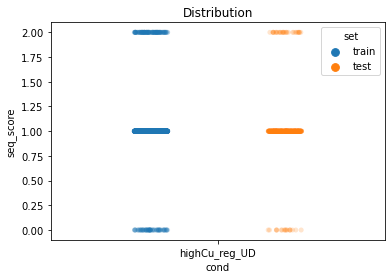

TRAIN
1    1556
2     125
0      74
Name: highCu_reg_UD, dtype: int64
TEST
1    390
2     31
0     18
Name: highCu_reg_UD, dtype: int64

_____Split 1____


/home/ubuntu/workspace/mbur-sequence-learning/viz.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['set'] = 'train'
/home/ubuntu/workspace/mbur-sequence-learning/viz.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['set'] = 'test'


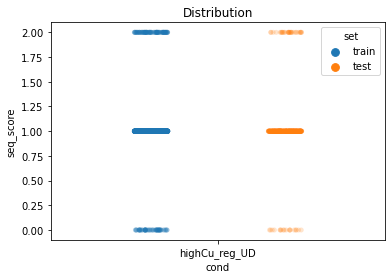

TRAIN
1    1557
2     124
0      74
Name: highCu_reg_UD, dtype: int64
TEST
1    389
2     32
0     18
Name: highCu_reg_UD, dtype: int64

_____Split 2____


/home/ubuntu/workspace/mbur-sequence-learning/viz.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['set'] = 'train'
/home/ubuntu/workspace/mbur-sequence-learning/viz.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['set'] = 'test'


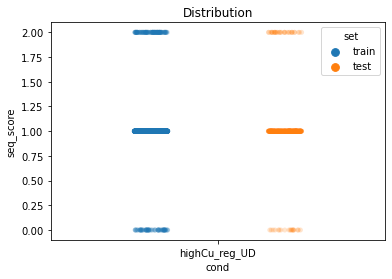

TRAIN
1    1557
2     125
0      73
Name: highCu_reg_UD, dtype: int64
TEST
1    389
2     31
0     19
Name: highCu_reg_UD, dtype: int64

_____Split 3____


/home/ubuntu/workspace/mbur-sequence-learning/viz.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['set'] = 'train'
/home/ubuntu/workspace/mbur-sequence-learning/viz.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['set'] = 'test'


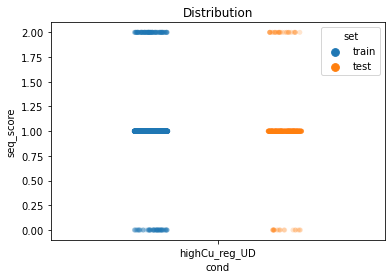

TRAIN
1    1557
2     125
0      73
Name: highCu_reg_UD, dtype: int64
TEST
1    389
2     31
0     19
Name: highCu_reg_UD, dtype: int64

_____Split 4____


/home/ubuntu/workspace/mbur-sequence-learning/viz.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['set'] = 'train'
/home/ubuntu/workspace/mbur-sequence-learning/viz.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['set'] = 'test'


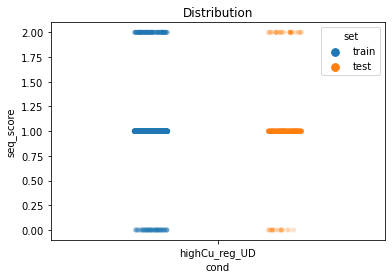

TRAIN
1    1557
2     125
0      74
Name: highCu_reg_UD, dtype: int64
TEST
1    389
2     31
0     18
Name: highCu_reg_UD, dtype: int64



In [14]:
target_col = 'highCu_reg_UD'
id_col = 'locus_tag'
outdir = 'highCu_cls_splits'
make_kfold_splits_for_cls(XYdf,target_col, id_col,skf, outdir)

### Create splits for logTPM regression

In [15]:
data_filename = "data/XY_logTPM_opFilt_20221031.tsv"
log_tpm_df = pd.read_csv(data_filename,sep='\t')
log_tpm_df

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,lowCu,highO2_slow_growth,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum,LanzaTech,aa3_KO,crotonic_acid,CH4_500ppm,CH4_1000ppm
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,5.478624,5.057673,4.896853,4.490890,5.145182,5.397970,5.405936,5.192777,5.969066,4.930030,5.027548,4.964473,4.628472,4.672580,5.203285,5.813802,5.360335
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,5.690592,5.327593,5.018030,4.187744,5.511274,5.929589,6.122296,5.687118,6.581135,5.375959,5.266481,5.349840,5.748453,5.432198,5.643963,5.048957,5.021201
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,4.863056,4.668366,4.159345,4.151060,4.498207,4.786031,4.885784,4.585745,5.439145,4.344218,4.249195,4.431874,3.510871,3.507901,4.979830,4.642674,4.258694
3,4,EQU24_RS00035,GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...,6.236072,6.078456,6.178559,5.400475,6.042533,6.231928,6.387618,6.075307,6.562648,5.781786,6.685816,6.608930,5.090150,5.577019,6.052065,6.409572,6.737678
4,9,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,4.553060,4.663626,3.639238,3.367896,4.379804,4.595742,4.686595,4.444783,4.238753,4.453061,4.918992,5.002460,3.663770,4.354762,4.450588,4.012562,4.059889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,4182,EQU24_RS23145,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,11.237420,11.335500,10.863092,9.018391,10.617199,10.788779,11.118496,10.625349,10.234527,12.057299,11.594911,12.181570,11.319127,12.194560,11.395111,11.080633,11.344901
2207,4184,EQU24_RS23155,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,11.240275,11.332696,10.861885,9.015633,10.630280,10.784309,11.113859,10.624571,10.255792,12.052196,11.583235,12.178662,11.331736,12.203430,11.391490,11.064205,11.335484
2208,4186,EQU24_RS23165,TTGAAACCCTAAGGTACATTGAGGCGTTAGCAAAGAGCAAGTTTGA...,11.245186,11.327803,10.873490,9.044817,10.639739,10.811677,11.125770,10.655103,10.317302,12.046530,11.539422,12.082225,11.348469,12.160149,11.409383,10.671998,10.945555
2209,4187,EQU24_RS23170,AATCTTCATTAGAGTCGAACGAAGTTTCATGTTTTCGGCTTCCTCA...,5.687342,5.279725,4.821525,5.208461,5.082854,5.068202,5.311955,4.899572,5.240644,4.812318,4.849694,5.189988,5.348046,4.212482,5.896935,4.837302,4.797353


In [16]:
# Add shuffled seq for later null comparisons
log_tpm_df['shuffled_seq'] = log_tpm_df['upstream_region'].apply(lambda x: u.shuffle_seq(x))

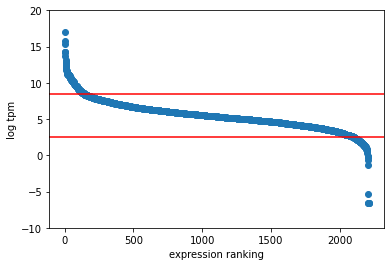

In [17]:
hicu = sorted(log_tpm_df['highCu'].values, reverse=True)

x,y = list(zip(*enumerate(hicu)))
plt.scatter(x,y)
#plt.yscale('log')
plt.ylim(-10,20)
plt.axhline(8.5,c='red')
plt.axhline(2.5,c='red')
plt.xlabel('expression ranking')
plt.ylabel('log tpm')
plt.show()

Some promoters in M. buryatense have very similar upstream regions. To prevent "leakage" between the train/test sets, load in the "promoter connected componenets" - an id from a promoter similarity BLAST analysis. Group K Fold should make sure that promoters in the same connected component (aka highly similar in sequence) all end up in either train or test, but not split across them.

In [18]:
# load connected component map
loc2cc = dict(pd.read_csv('data/loc2ccid_aln200_pident90.tsv',sep='\t').values)

def get_ccid(locus):
    '''
    If the locus is not yet in the cc dict, give it the 
    id of +1 of the max value in the dict. Add it to 
    the dict so the next id increments.
    '''
    new_id = max(loc2cc.values())+1
    if locus in loc2cc:
        return loc2cc[locus]
    else:
        loc2cc[locus] = new_id
        return new_id

log_tpm_df['cc_id'] = log_tpm_df['locus_tag'].apply(lambda x: get_ccid(x))
log_tpm_df

,og_index,locus_tag,upstream_region,uMax,lowO2_fast_growth,lowCH4,MeOH,NoCu,medCu,highCu,...,NO3_lowO2_slow_growth,WithLanthanum,NoLanthanum,LanzaTech,aa3_KO,crotonic_acid,CH4_500ppm,CH4_1000ppm,shuffled_seq,cc_id
0,0,EQU24_RS00005,ACTGTTAGCTTGGCACGGCCCTTGGCTCTGCGGGCGTTAAGGACTT...,5.478624,5.057673,4.896853,4.490890,5.145182,5.397970,5.405936,...,4.930030,5.027548,4.964473,4.628472,4.672580,5.203285,5.813802,5.360335,GCTTACGTGTGATCGAAGAAACTGTGGACGTTGGGTTTCTGCTATA...,178
1,1,EQU24_RS00010,GTGGACGCGATCACACCACGGTTATTAATGCTTGTAAACGCATTGC...,5.690592,5.327593,5.018030,4.187744,5.511274,5.929589,6.122296,...,5.375959,5.266481,5.349840,5.748453,5.432198,5.643963,5.048957,5.021201,AACGTTCAGAACGTATTCTGTATGATTTCTTTTAGATGCAATTCCT...,179
2,2,EQU24_RS00015,TTGCGAAGAGGGGCGGTTTCTCGTCCGACAGGCGTCGGCGGCAAGG...,4.863056,4.668366,4.159345,4.151060,4.498207,4.786031,4.885784,...,4.344218,4.249195,4.431874,3.510871,3.507901,4.979830,4.642674,4.258694,AGATATCGCTCTTGTTCCCGCACCTAACCCTGCGCTTATTTCTCTA...,180
3,4,EQU24_RS00035,GTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTA...,6.236072,6.078456,6.178559,5.400475,6.042533,6.231928,6.387618,...,5.781786,6.685816,6.608930,5.090150,5.577019,6.052065,6.409572,6.737678,AATACGTTGGCTTTGATCCGGATTCGGGAACGGTTATAGTTGTTGC...,181
4,9,EQU24_RS00060,GAATTTTCGGGTTCGGGCATCAGCTACCGGGTATCGCCGGTACTCG...,4.553060,4.663626,3.639238,3.367896,4.379804,4.595742,4.686595,...,4.453061,4.918992,5.002460,3.663770,4.354762,4.450588,4.012562,4.059889,CATACATGGATTACTATCCAAAGGGGCAAACTTCAGCAGCTCCGGA...,182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2206,4182,EQU24_RS23145,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,11.237420,11.335500,10.863092,9.018391,10.617199,10.788779,11.118496,...,12.057299,11.594911,12.181570,11.319127,12.194560,11.395111,11.080633,11.344901,AGGGGCATGAATAAAAAATTACCTAATCGAACTCCCAAAAGATTGA...,177
2207,4184,EQU24_RS23155,TTCCGAAAATAAATTGATTTCAAGCGATATACGGGTAGTCGGGTTA...,11.240275,11.332696,10.861885,9.015633,10.630280,10.784309,11.113859,...,12.052196,11.583235,12.178662,11.331736,12.203430,11.391490,11.064205,11.335484,ATGGTTACACAGCGGGCAAGGGTACGATATCGTTTCGTCACCACTA...,177
2208,4186,EQU24_RS23165,TTGAAACCCTAAGGTACATTGAGGCGTTAGCAAAGAGCAAGTTTGA...,11.245186,11.327803,10.873490,9.044817,10.639739,10.811677,11.125770,...,12.046530,11.539422,12.082225,11.348469,12.160149,11.409383,10.671998,10.945555,ATCAATCCATTGAAACGTAATGGGATTGATACCCTTGACTAATTTA...,171
2209,4187,EQU24_RS23170,AATCTTCATTAGAGTCGAACGAAGTTTCATGTTTTCGGCTTCCTCA...,5.687342,5.279725,4.821525,5.208461,5.082854,5.068202,5.311955,...,4.812318,4.849694,5.189988,5.348046,4.212482,5.896935,4.837302,4.797353,TATTTTTGATGTCGATCTGGAAATGAACGTTACTCGATTTTGTCAG...,1962


In [19]:
from sklearn.model_selection import GroupKFold#,GroupShuffleSplit

In [20]:
# Make K fold splits
def make_groupkfold_splits_for_reg(df,target_col, id_col,group_col,splitter,outdir):
    groups = df[group_col].values
    
    for i, (train_idxs, test_idxs) in enumerate(splitter.split(df, groups=groups)):
        print(f"_____Split {i}____")
        train_df = df.iloc[train_idxs]
        test_df = df.iloc[test_idxs]

        v.plot_train_test_hist(train_df, test_df,score_col=target_col,bins=200)
        v.view_train_test_dist(train_df, test_df,[target_col],id_col=id_col)
#         print("TRAIN")
#         print(train_df[target_col].value_counts())
#         print("TEST")
#         print(test_df[target_col].value_counts())
#         print("")
        train_vc = train_df[group_col].value_counts().reset_index()
        test_vc = test_df[group_col].value_counts().reset_index()
        
        plt.figure(figsize=(15,5))
        plt.bar(train_vc['index'],train_vc[group_col],label="Train split")
        plt.bar(test_vc['index'],test_vc[group_col],label="Test split")
        plt.yscale('log')
        plt.xlabel("connected component id")
        plt.ylabel("count of genes in connected component")
        plt.legend()
        plt.show()

        train_df.to_csv(f'data/{outdir}/cv{i}_train.tsv',index=False,sep='\t')
        test_df.to_csv(f'data/{outdir}/cv{i}_test.tsv',index=False,sep='\t')


_____Split 0____


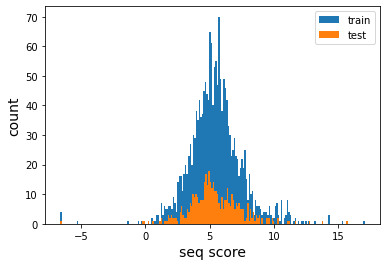

/home/ubuntu/workspace/mbur-sequence-learning/viz.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['set'] = 'train'
/home/ubuntu/workspace/mbur-sequence-learning/viz.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['set'] = 'test'


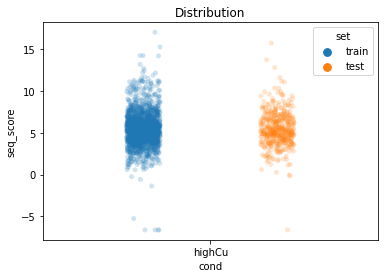

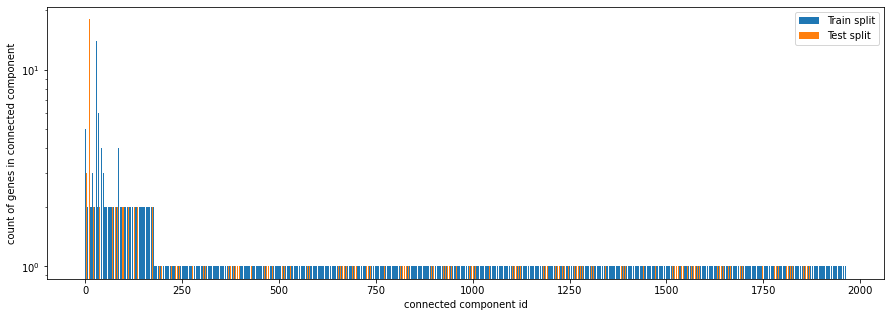

_____Split 1____


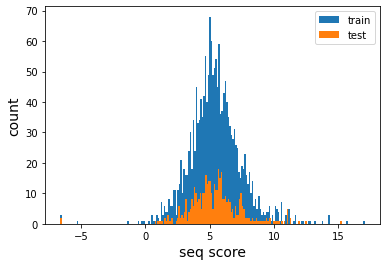

/home/ubuntu/workspace/mbur-sequence-learning/viz.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['set'] = 'train'
/home/ubuntu/workspace/mbur-sequence-learning/viz.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['set'] = 'test'


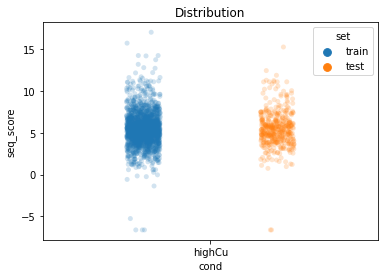

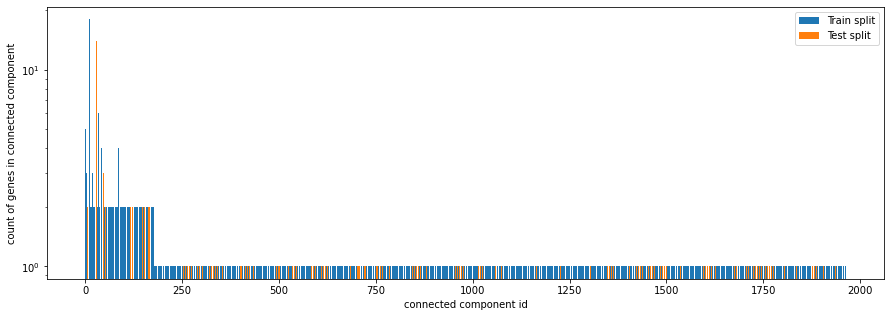

_____Split 2____


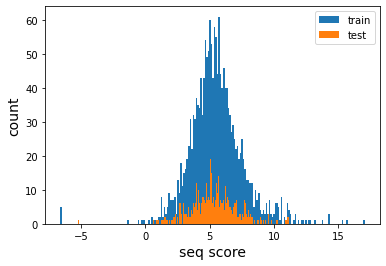

/home/ubuntu/workspace/mbur-sequence-learning/viz.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['set'] = 'train'
/home/ubuntu/workspace/mbur-sequence-learning/viz.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['set'] = 'test'


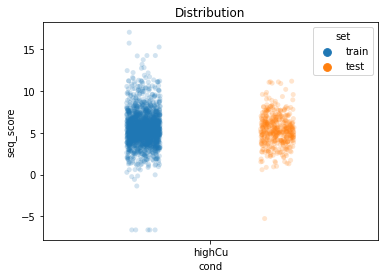

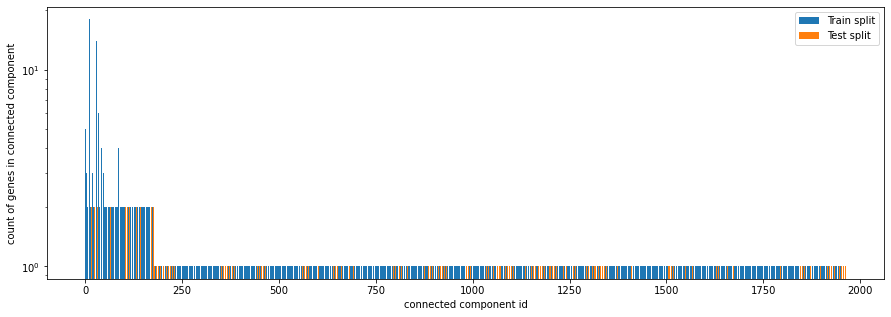

_____Split 3____


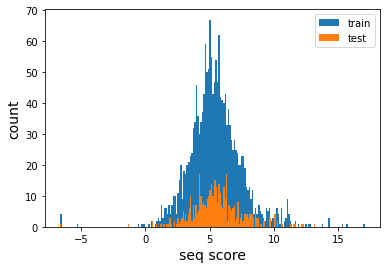

/home/ubuntu/workspace/mbur-sequence-learning/viz.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['set'] = 'train'
/home/ubuntu/workspace/mbur-sequence-learning/viz.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['set'] = 'test'


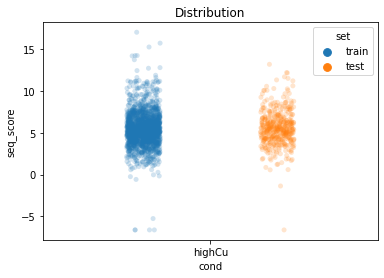

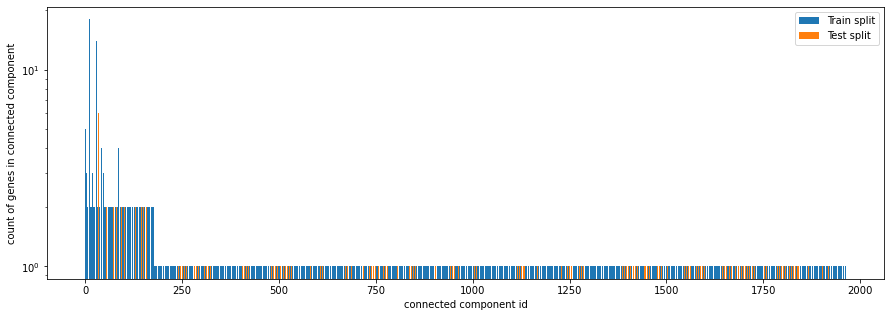

_____Split 4____


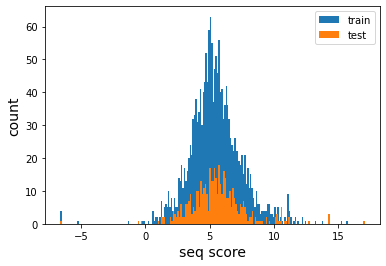

/home/ubuntu/workspace/mbur-sequence-learning/viz.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['set'] = 'train'
/home/ubuntu/workspace/mbur-sequence-learning/viz.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['set'] = 'test'


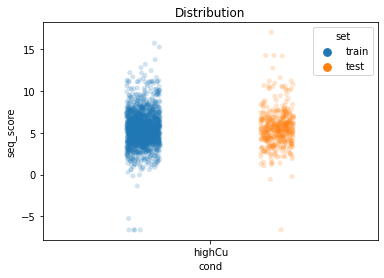

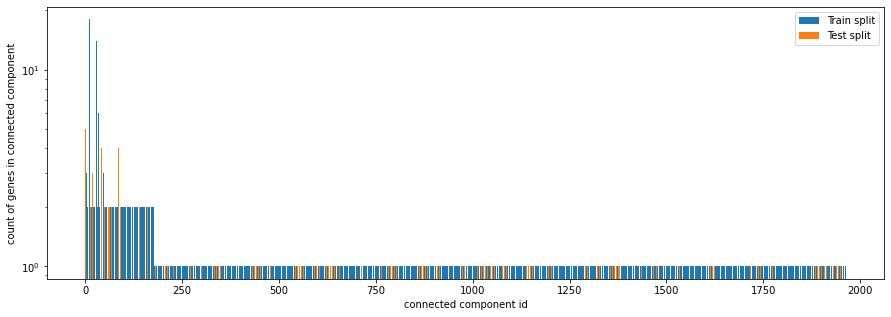

In [21]:
gkf = GroupKFold(n_splits=5)

target_col = 'highCu'
id_col = 'locus_tag'
group_col = 'cc_id'
outdir = 'highCu_logTPM_reg_splits'

make_groupkfold_splits_for_reg(log_tpm_df,target_col, id_col,group_col,gkf, outdir)

# 2. Run cold start models for Copper classification and Regression tasks

## Train a cold model on CU classification

In [22]:
# FOR LOOP going through splits we just made above?
model_res = {}
pred_dfs = {}


### Run 5 folds for regular sequences (non-shuffled)

___Running CV0___


E:172 | train loss:0.047 | val loss: 0.851:   3%|▎         | 173/5000 [00:15<06:16, 12.81it/s]

EarlyStopping counter: 125 out of 500


E:297 | train loss:0.018 | val loss: 1.005:   6%|▌         | 297/5000 [00:24<06:04, 12.90it/s]

EarlyStopping counter: 250 out of 500


E:422 | train loss:0.009 | val loss: 1.095:   8%|▊         | 423/5000 [00:34<05:55, 12.89it/s]

EarlyStopping counter: 375 out of 500


E:545 | train loss:0.012 | val loss: 1.127:  11%|█         | 545/5000 [00:43<05:59, 12.39it/s]


EarlyStopping counter: 500 out of 500
Early stopping


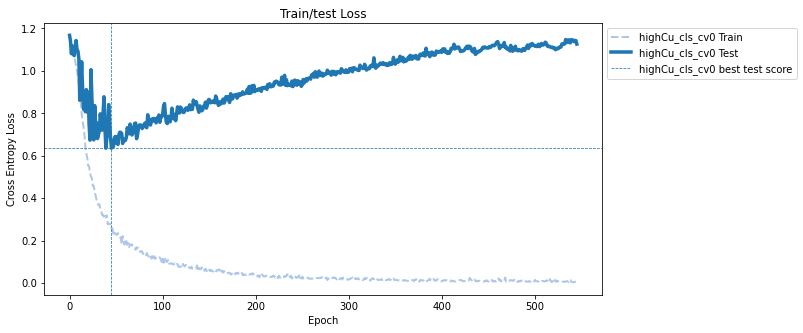

Running predictions for highCu_cls_cv0
___Running CV1___


E:153 | train loss:0.073 | val loss: 0.983:   3%|▎         | 154/5000 [00:12<06:17, 12.85it/s]

EarlyStopping counter: 125 out of 500


E:278 | train loss:0.022 | val loss: 1.156:   6%|▌         | 278/5000 [00:21<06:07, 12.86it/s]

EarlyStopping counter: 250 out of 500


E:403 | train loss:0.016 | val loss: 1.277:   8%|▊         | 404/5000 [00:31<06:12, 12.35it/s]

EarlyStopping counter: 375 out of 500


E:526 | train loss:0.006 | val loss: 1.274:  11%|█         | 526/5000 [00:41<05:51, 12.74it/s]


EarlyStopping counter: 500 out of 500
Early stopping


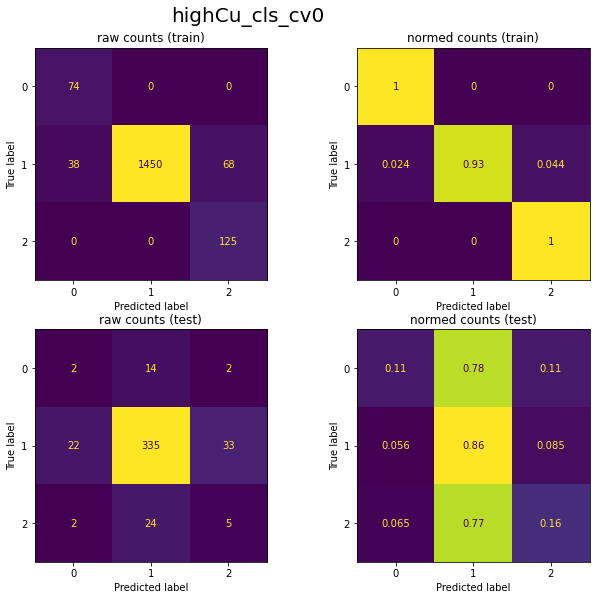

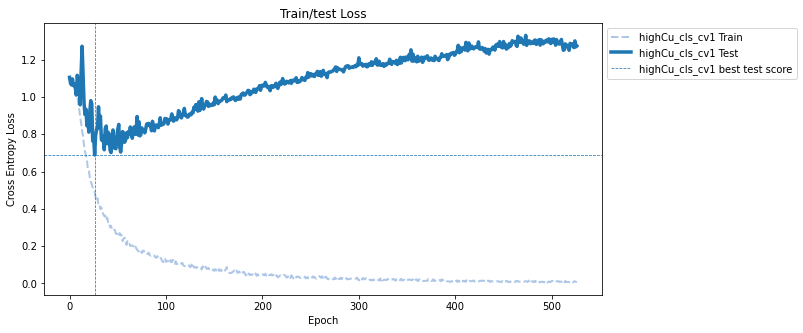

Running predictions for highCu_cls_cv1
___Running CV2___


E:175 | train loss:0.043 | val loss: 0.943:   4%|▎         | 176/5000 [00:14<06:17, 12.79it/s]

EarlyStopping counter: 125 out of 500


E:300 | train loss:0.016 | val loss: 1.096:   6%|▌         | 300/5000 [00:23<06:06, 12.82it/s]

EarlyStopping counter: 250 out of 500


E:425 | train loss:0.012 | val loss: 1.188:   9%|▊         | 426/5000 [00:33<05:55, 12.88it/s]

EarlyStopping counter: 375 out of 500


E:548 | train loss:0.003 | val loss: 1.274:  11%|█         | 548/5000 [00:43<05:49, 12.72it/s]


EarlyStopping counter: 500 out of 500
Early stopping


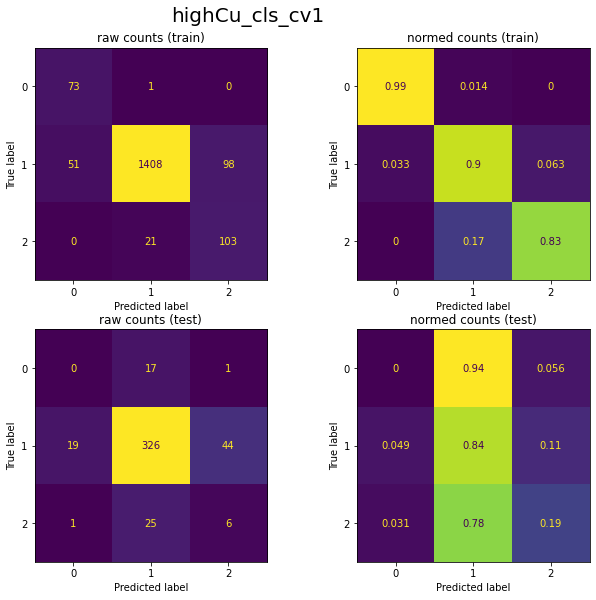

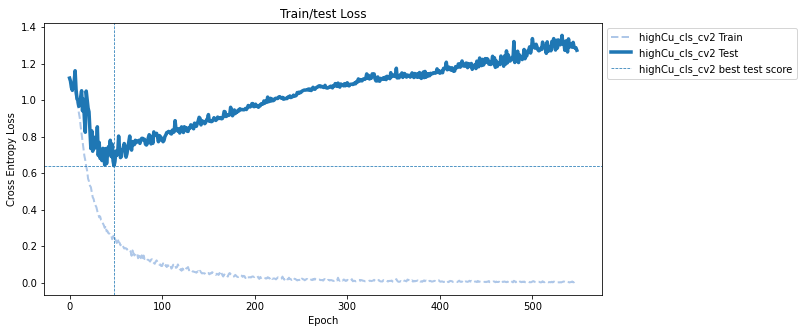

Running predictions for highCu_cls_cv2
___Running CV3___


E:158 | train loss:0.069 | val loss: 0.918:   3%|▎         | 159/5000 [00:12<06:15, 12.89it/s]

EarlyStopping counter: 125 out of 500


E:283 | train loss:0.021 | val loss: 1.047:   6%|▌         | 283/5000 [00:22<06:05, 12.90it/s]

EarlyStopping counter: 250 out of 500


E:408 | train loss:0.016 | val loss: 1.156:   8%|▊         | 409/5000 [00:32<06:03, 12.62it/s]

EarlyStopping counter: 375 out of 500


E:531 | train loss:0.009 | val loss: 1.198:  11%|█         | 531/5000 [00:41<05:51, 12.73it/s]


EarlyStopping counter: 500 out of 500
Early stopping


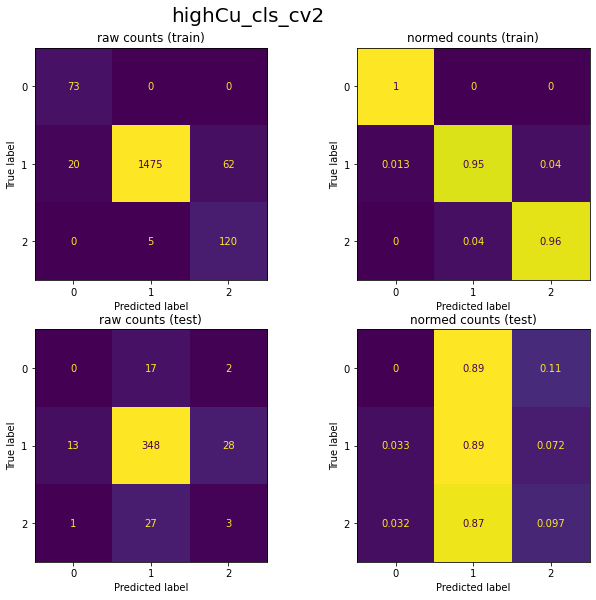

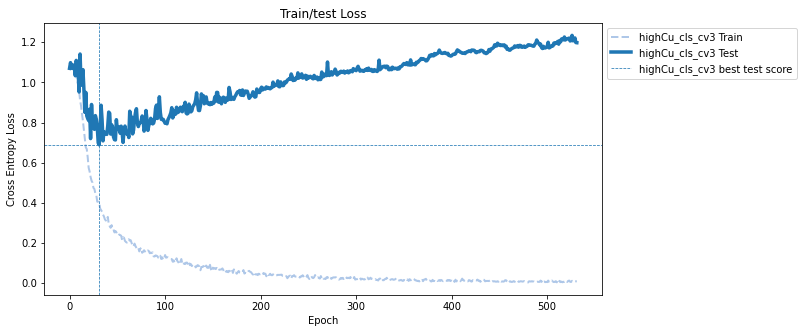

Running predictions for highCu_cls_cv3
___Running CV4___


E:153 | train loss:0.071 | val loss: 0.832:   3%|▎         | 154/5000 [00:12<06:18, 12.79it/s]

EarlyStopping counter: 125 out of 500


E:278 | train loss:0.018 | val loss: 0.968:   6%|▌         | 278/5000 [00:21<06:06, 12.87it/s]

EarlyStopping counter: 250 out of 500


E:403 | train loss:0.010 | val loss: 1.070:   8%|▊         | 404/5000 [00:31<05:59, 12.77it/s]

EarlyStopping counter: 375 out of 500


E:526 | train loss:0.002 | val loss: 1.134:  11%|█         | 526/5000 [00:41<05:51, 12.74it/s]


EarlyStopping counter: 500 out of 500
Early stopping


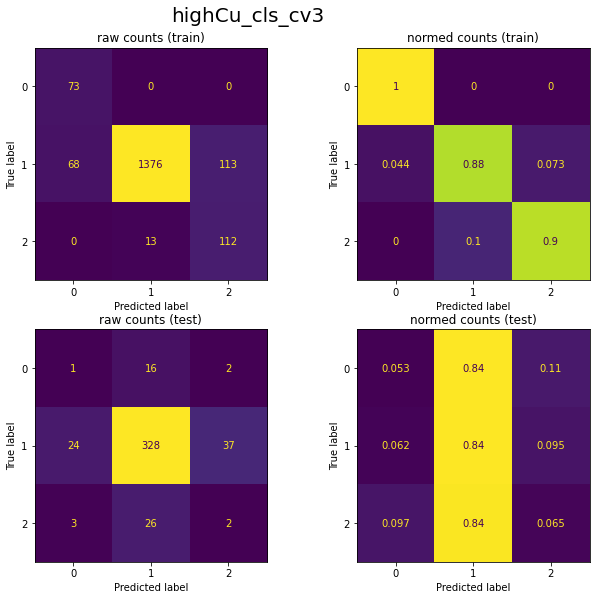

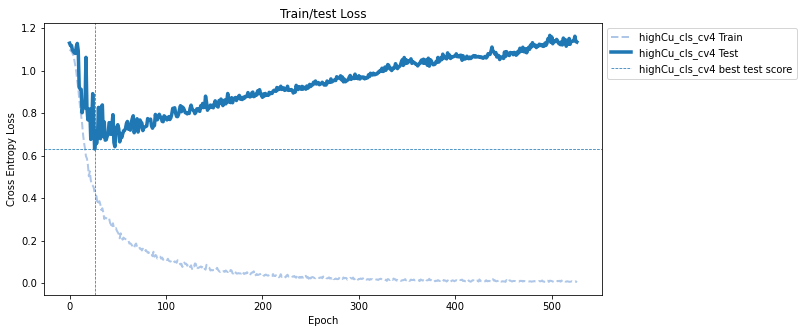

Running predictions for highCu_cls_cv4


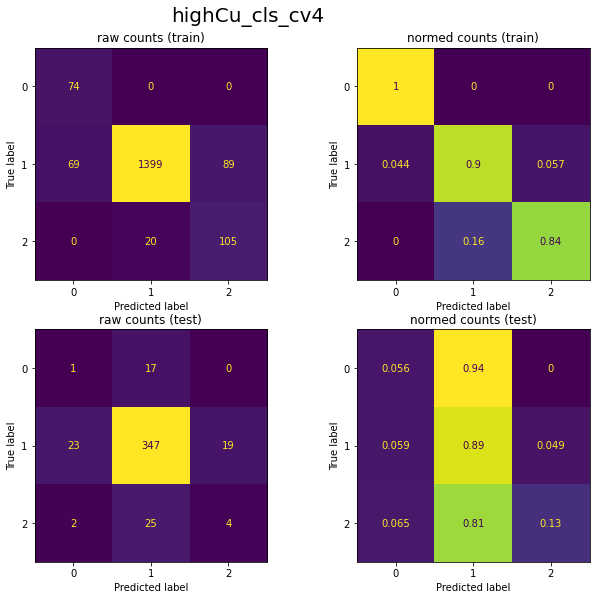

In [23]:
target_col = 'highCu_reg_UD'
seq_col = 'upstream_region'

# for each cv
for i in [0,1,2,3,4]:
    print(f"___Running CV{i}___")
    train_df = pd.read_csv(f'data/highCu_cls_splits/cv{i}_train.tsv',sep='\t')
    test_df = pd.read_csv(f'data/highCu_cls_splits/cv{i}_test.tsv',sep='\t')
    seq_len = len(train_df[seq_col].values[0])
    
    # sequences to predict on after training
    seq_list = [
        (train_df[seq_col].values,train_df[target_col],"train"),
        (test_df[seq_col].values,test_df[target_col],"test")
    ]

    # create data loaders
    sampler = tu.make_weighted_sampler(train_df,target_col)
    
    dataset_types = [
        DatasetSpec('ohe'),
    ]

    dls = tu.build_dataloaders(
                    train_df, 
                    test_df, 
                    dataset_types, # just OHE for now
                    seq_col=seq_col,
                    target_col=target_col,
                    sampler=sampler,
                    shuffle=False,
                )
    ohe_train_dl,ohe_val_dl = dls['ohe']
    
    m_args = (seq_len,3)
    m_kwargs = {
        "num_filters1":32,
        "num_filters2":32,
        "kernel_size1":10,
        "kernel_size2":6,
        "conv_pool_size1":2,
        "fc_node_num1":50,
        "fc_node_num2":50,
        "dropout1":0.25
    }
    
    model = m.DNA_2CNN_2FC(*m_args,**m_kwargs)
    model_name = f"highCu_cls_cv{i}"

    # +-------------+
    # | TRAIN MODEL |
    # +-------------+
    t_res = tu.collect_model_stats(
        model_name,
        seq_len,
        ohe_train_dl,
        ohe_val_dl,
        DEVICE,
        lr=0.0001,
        ep=5000,
        pat=500,
        opt=torch.optim.Adam,
        model=model,
        loss_type='classification'
    )
#     tu.quick_loss_plot(
#         t_res['data_label'],
#         title=f"{model_name} Loss Curve",
#         #save_file=f"{out_dir}/{model_name}_loss_plot.png"
#     )
    model_res[model_name] = t_res
    
    # +------------+
    # | EVAL MODEL |
    # +------------+
    p_res_df = tu.get_confusion_stats(
        t_res['model'],
        t_res['model_name'],
        seq_list,
        DEVICE,
        title=f"{t_res['model_name']}",
        #save_file=f"{out_dir}/{model_name}_confmat.png"
    )
    p_res_df['model_type'] = "CNN"
    p_res_df['seq_mode'] = "regular"
    p_res_df['fold'] = i # which cv split
    p_res_df['task'] = 'highCu_cls'
    p_res_df['best_val_score'] = t_res['best_val_score']
    p_res_df['epoch_stop'] = t_res['epoch_stop']
    p_res_df['total_time'] = t_res['total_time']
    
    pred_dfs[model_name] = p_res_df
    
    
    
    

### Run for shuffled sequences

___Running CV0___


E:180 | train loss:0.055 | val loss: 0.828:   4%|▎         | 180/5000 [00:14<06:20, 12.65it/s]

EarlyStopping counter: 125 out of 500


E:305 | train loss:0.023 | val loss: 0.951:   6%|▌         | 306/5000 [00:24<06:04, 12.86it/s]

EarlyStopping counter: 250 out of 500


E:430 | train loss:0.012 | val loss: 1.021:   9%|▊         | 430/5000 [00:33<05:55, 12.86it/s]

EarlyStopping counter: 375 out of 500


E:553 | train loss:0.008 | val loss: 1.069:  11%|█         | 553/5000 [00:43<05:50, 12.68it/s]


EarlyStopping counter: 500 out of 500
Early stopping


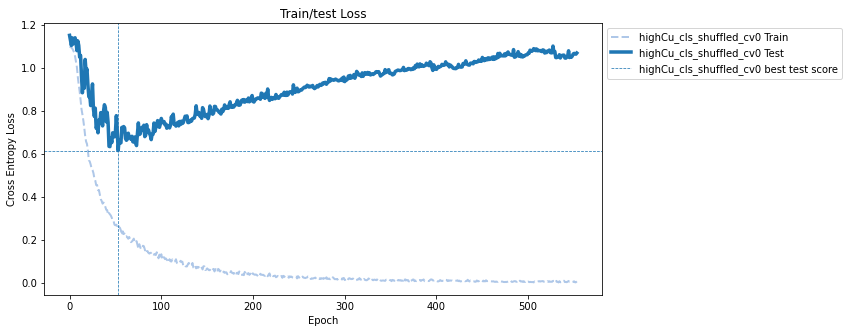

Running predictions for highCu_cls_shuffled_cv0
___Running CV1___


E:168 | train loss:0.076 | val loss: 0.947:   3%|▎         | 169/5000 [00:13<06:27, 12.46it/s]

EarlyStopping counter: 125 out of 500


E:293 | train loss:0.020 | val loss: 1.093:   6%|▌         | 293/5000 [00:23<06:32, 11.99it/s]

EarlyStopping counter: 250 out of 500


E:418 | train loss:0.010 | val loss: 1.185:   8%|▊         | 419/5000 [00:33<06:11, 12.32it/s]

EarlyStopping counter: 375 out of 500


E:541 | train loss:0.009 | val loss: 1.268:  11%|█         | 541/5000 [00:43<06:01, 12.34it/s]


EarlyStopping counter: 500 out of 500
Early stopping


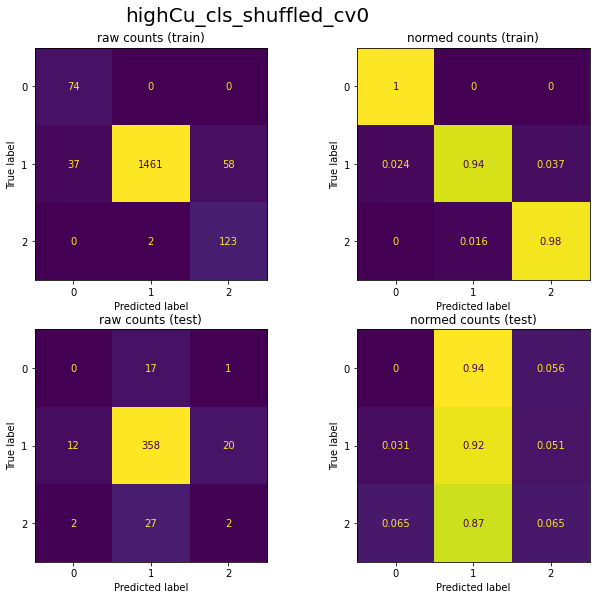

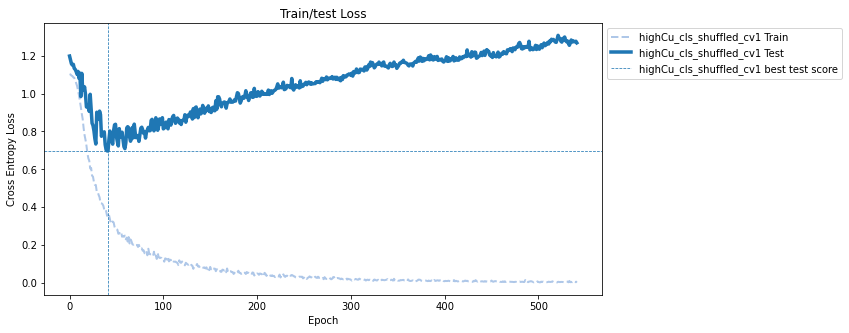

Running predictions for highCu_cls_shuffled_cv1
___Running CV2___


E:165 | train loss:0.051 | val loss: 0.980:   3%|▎         | 166/5000 [00:13<06:29, 12.40it/s]

EarlyStopping counter: 125 out of 500


E:290 | train loss:0.018 | val loss: 1.109:   6%|▌         | 290/5000 [00:23<06:17, 12.47it/s]

EarlyStopping counter: 250 out of 500


E:415 | train loss:0.010 | val loss: 1.223:   8%|▊         | 416/5000 [00:33<06:05, 12.55it/s]

EarlyStopping counter: 375 out of 500


E:538 | train loss:0.009 | val loss: 1.328:  11%|█         | 538/5000 [00:43<06:03, 12.27it/s]


EarlyStopping counter: 500 out of 500
Early stopping


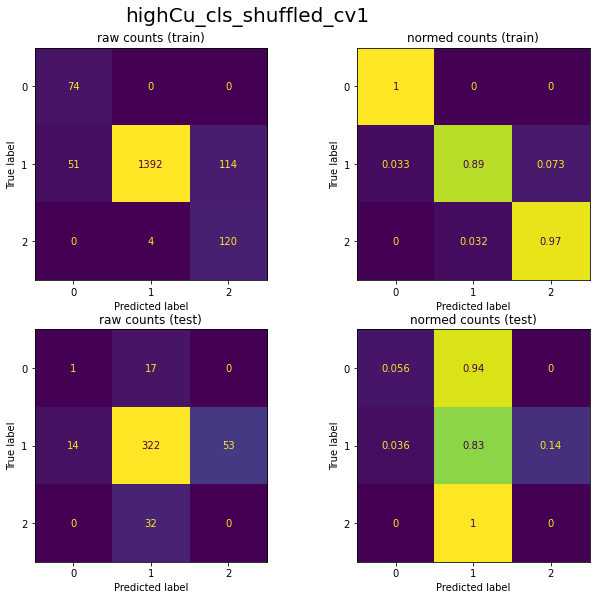

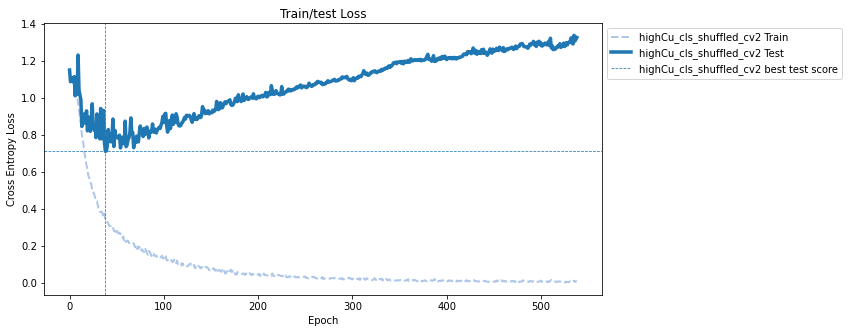

Running predictions for highCu_cls_shuffled_cv2
___Running CV3___


E:191 | train loss:0.044 | val loss: 0.861:   4%|▍         | 192/5000 [00:15<06:28, 12.38it/s]

EarlyStopping counter: 125 out of 500


E:316 | train loss:0.011 | val loss: 0.952:   6%|▋         | 316/5000 [00:25<06:14, 12.50it/s]

EarlyStopping counter: 250 out of 500


E:441 | train loss:0.007 | val loss: 1.067:   9%|▉         | 442/5000 [00:35<06:04, 12.51it/s]

EarlyStopping counter: 375 out of 500


E:564 | train loss:0.004 | val loss: 1.173:  11%|█▏        | 564/5000 [00:45<05:59, 12.34it/s]


EarlyStopping counter: 500 out of 500
Early stopping


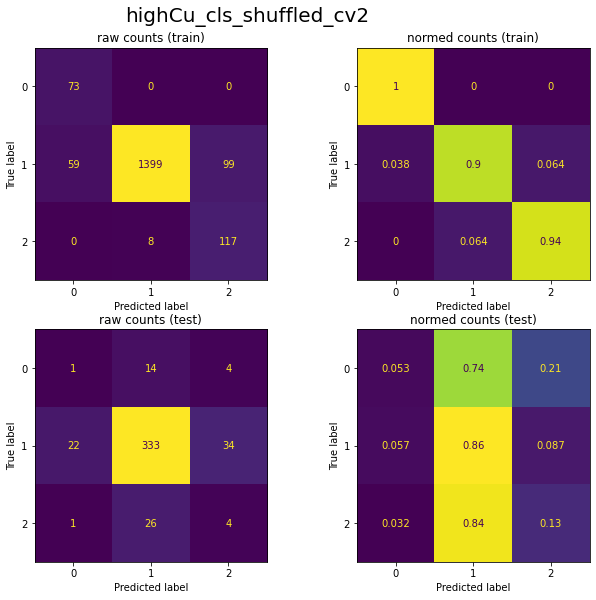

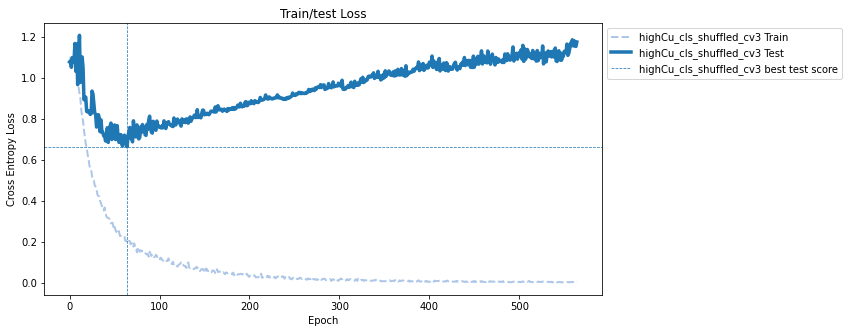

Running predictions for highCu_cls_shuffled_cv3
___Running CV4___


E:151 | train loss:0.074 | val loss: 0.961:   3%|▎         | 151/5000 [00:12<06:38, 12.18it/s]

EarlyStopping counter: 125 out of 500


E:276 | train loss:0.022 | val loss: 1.183:   6%|▌         | 277/5000 [00:22<06:14, 12.61it/s]

EarlyStopping counter: 250 out of 500


E:401 | train loss:0.014 | val loss: 1.356:   8%|▊         | 401/5000 [00:32<06:14, 12.28it/s]

EarlyStopping counter: 375 out of 500


E:524 | train loss:0.007 | val loss: 1.446:  10%|█         | 524/5000 [00:42<06:01, 12.38it/s]


EarlyStopping counter: 500 out of 500
Early stopping


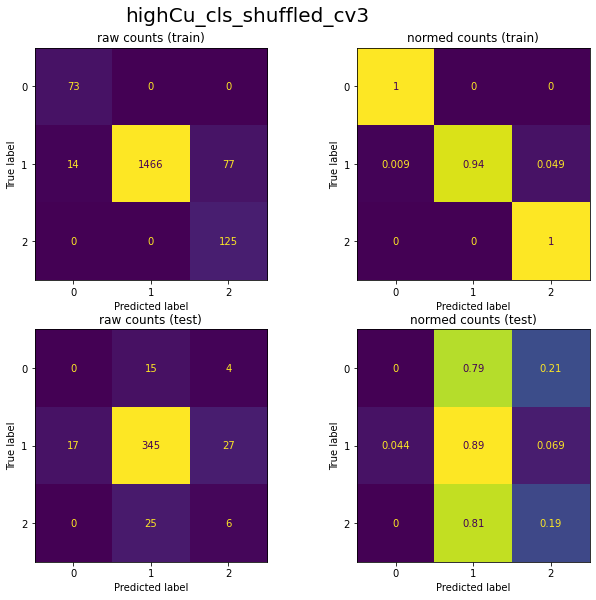

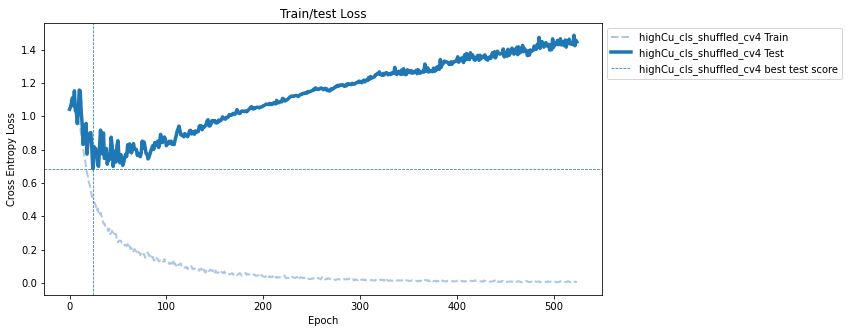

Running predictions for highCu_cls_shuffled_cv4


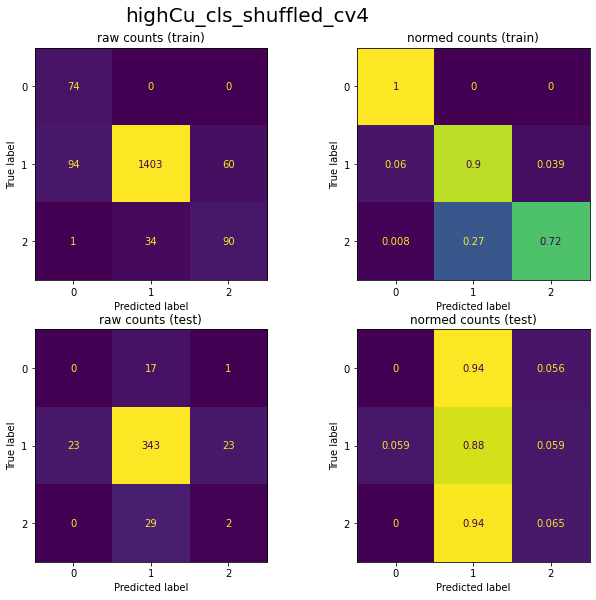

In [24]:
target_col = 'highCu_reg_UD'
seq_col = 'shuffled_seq'

# for each cv
for i in [0,1,2,3,4]:
    print(f"___Running CV{i}___")
    train_df = pd.read_csv(f'data/highCu_cls_splits/cv{i}_train.tsv',sep='\t')
    test_df = pd.read_csv(f'data/highCu_cls_splits/cv{i}_test.tsv',sep='\t')
    seq_len = len(train_df[seq_col].values[0])
    
    # sequences to predict on after training
    seq_list = [
        (train_df[seq_col].values,train_df[target_col],"train"),
        (test_df[seq_col].values,test_df[target_col],"test")
    ]

    # create data loaders
    sampler = tu.make_weighted_sampler(train_df,target_col)
    
    dataset_types = [
        DatasetSpec('ohe'),
    ]

    dls = tu.build_dataloaders(
                    train_df, 
                    test_df, 
                    dataset_types, # just OHE for now
                    seq_col=seq_col,
                    target_col=target_col,
                    sampler=sampler,
                    shuffle=False,
                )
    ohe_train_dl,ohe_val_dl = dls['ohe']
    
    m_args = (seq_len,3)
    m_kwargs = {
        "num_filters1":32,
        "num_filters2":32,
        "kernel_size1":10,
        "kernel_size2":6,
        "conv_pool_size1":2,
        "fc_node_num1":50,
        "fc_node_num2":50,
        "dropout1":0.25
    }
    
    model = m.DNA_2CNN_2FC(*m_args,**m_kwargs)
    model_name = f"highCu_cls_shuffled_cv{i}"

    # +-------------+
    # | TRAIN MODEL |
    # +-------------+
    t_res = tu.collect_model_stats(
        model_name,
        seq_len,
        ohe_train_dl,
        ohe_val_dl,
        DEVICE,
        lr=0.0001,
        ep=5000,
        pat=500,
        opt=torch.optim.Adam,
        model=model,
        loss_type='classification'
    )
#     tu.quick_loss_plot(
#         t_res['data_label'],
#         title=f"{model_name} Loss Curve",
#         #save_file=f"{out_dir}/{model_name}_loss_plot.png"
#     )
    model_res[model_name] = t_res
    
    # +------------+
    # | EVAL MODEL |
    # +------------+
    p_res_df = tu.get_confusion_stats(
        t_res['model'],
        t_res['model_name'],
        seq_list,
        DEVICE,
        title=f"{t_res['model_name']}",
        #save_file=f"{out_dir}/{model_name}_confmat.png"
    )
    p_res_df['model_type'] = "CNN"
    p_res_df['seq_mode'] = "shuffled"
    p_res_df['fold'] = i # which cv split
    p_res_df['task'] = 'highCu_cls'
    p_res_df['best_val_score'] = t_res['best_val_score']
    p_res_df['epoch_stop'] = t_res['epoch_stop']
    p_res_df['total_time'] = t_res['total_time']
    
    pred_dfs[model_name] = p_res_df
    
    

## Compare overall predictions

In [25]:
all_preds = pd.concat([pred_dfs[x] for x in pred_dfs])
all_preds

,model_name,split,mac_precision,mac_recall,mac_f1,support,model_type,seq_mode,fold,best_val_score,epoch_stop,total_time
0,highCu_cls_cv0,train,0.769461,0.977292,0.848867,1755,CNN,regular,0,0.635322,45,43.984181
1,highCu_cls_cv0,test,0.366682,0.377125,0.369956,439,CNN,regular,0,0.635322,45,43.984181
0,highCu_cls_cv1,train,0.695254,0.907145,0.771324,1755,CNN,regular,1,0.688871,26,41.303947
1,highCu_cls_cv1,test,0.334506,0.341849,0.335291,439,CNN,regular,1,0.688871,26,41.303947
0,highCu_cls_cv2,train,0.813636,0.969112,0.877543,1755,CNN,regular,2,0.641168,48,43.077116
1,highCu_cls_cv2,test,0.326221,0.330459,0.328305,439,CNN,regular,2,0.641168,48,43.077116
0,highCu_cls_cv3,train,0.668716,0.926584,0.752130,1755,CNN,regular,3,0.689606,31,41.726261
1,highCu_cls_cv3,test,0.323660,0.320112,0.320801,439,CNN,regular,3,0.689606,31,41.726261
0,highCu_cls_cv4,train,0.681542,0.912841,0.760174,1756,CNN,regular,4,0.631235,26,41.284132
1,highCu_cls_cv4,test,0.368135,0.358873,0.361878,438,CNN,regular,4,0.631235,26,41.284132


In [26]:
def plot_macf1(df):
    sns.barplot(data=df,y='model_name',x='mac_f1',hue='split',dodge=True)
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.xlabel("Macro F1 score",fontsize=14)
    plt.xticks(fontsize=14)
    plt.ylabel("")
    plt.yticks(fontsize=14)
    plt.show()

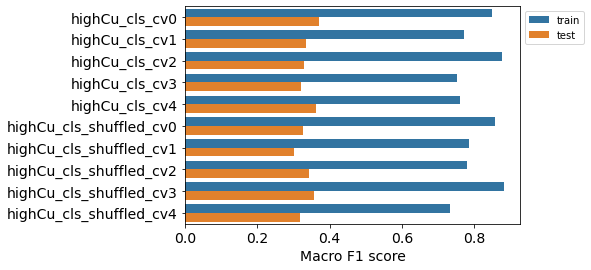

In [27]:
plot_macf1(all_preds)

In [70]:
df_train = all_preds[all_preds['split']=='train']
df_test = all_preds[all_preds['split']=='test']

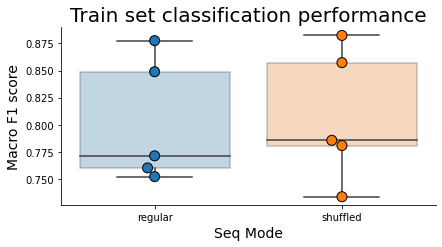

In [71]:
g = sns.catplot(
    data=df_train, x='seq_mode', y='mac_f1',
    kind='box',
    boxprops=dict(alpha=.3),height=3,aspect=4/2
)
g.map_dataframe(sns.swarmplot, 
                x='seq_mode', y='mac_f1',
                size=10, edgecolor='black',linewidth=1, dodge=True,palette='tab10')

for ax in g.axes.flatten():
    #ax.set_xlabel('Dataset size', fontsize=14)
    ax.set_ylabel('Macro F1 score', fontsize=14)
plt.xlabel("Seq Mode",fontsize=14)
plt.title("Train set classification performance",fontsize=20)
plt.show()

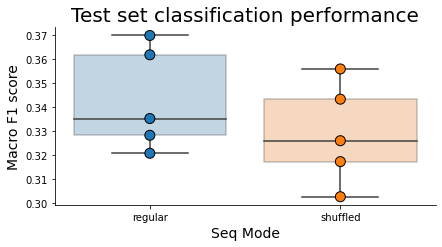

In [42]:
g = sns.catplot(
    data=df_test, x='seq_mode', y='mac_f1',
    kind='box',
    boxprops=dict(alpha=.3),height=3,aspect=4/2
)
g.map_dataframe(sns.swarmplot, 
                x='seq_mode', y='mac_f1',
                size=10, edgecolor='black',linewidth=1, dodge=True,palette='tab10')

for ax in g.axes.flatten():
    #ax.set_xlabel('Dataset size', fontsize=14)
    ax.set_ylabel('Macro F1 score', fontsize=14)
plt.xlabel("Seq Mode",fontsize=14)
plt.title("Test set classification performance",fontsize=20)
plt.show()

With this particular model set up, it appears that classifying expression behavior groups on wildtype sequences are slightly better than on shuffled sequences, but not by much. These means are not likely different. 

In [32]:
df_test

,model_name,split,mac_precision,mac_recall,mac_f1,support,model_type,seq_mode,fold,best_val_score,epoch_stop,total_time
1,highCu_cls_cv0,test,0.366682,0.377125,0.369956,439,CNN,regular,0,0.635322,45,43.984181
1,highCu_cls_cv1,test,0.334506,0.341849,0.335291,439,CNN,regular,1,0.688871,26,41.303947
1,highCu_cls_cv2,test,0.326221,0.330459,0.328305,439,CNN,regular,2,0.641168,48,43.077116
1,highCu_cls_cv3,test,0.323660,0.320112,0.320801,439,CNN,regular,3,0.689606,31,41.726261
1,highCu_cls_cv4,test,0.368135,0.358873,0.361878,438,CNN,regular,4,0.631235,26,41.284132
1,highCu_cls_shuffled_cv0,test,0.325835,0.327488,0.326038,439,CNN,shuffled,0,0.615555,53,43.604510
1,highCu_cls_shuffled_cv1,test,0.311530,0.294440,0.302658,439,CNN,shuffled,1,0.697113,41,43.838193
1,highCu_cls_shuffled_cv2,test,0.343222,0.345902,0.343372,439,CNN,shuffled,2,0.712185,38,43.839131
1,highCu_cls_shuffled_cv3,test,0.352755,0.360146,0.355981,439,CNN,shuffled,3,0.663091,64,45.708942
1,highCu_cls_shuffled_cv4,test,0.319557,0.315421,0.317308,438,CNN,shuffled,4,0.685574,24,42.334432


In [33]:
from scipy.stats import ttest_ind

In [34]:
regular_scores = df_test[df_test['seq_mode']=='regular']['mac_f1'].values
shuffled_scores = df_test[df_test['seq_mode']=='shuffled']['mac_f1'].values
ttest_ind(regular_scores, shuffled_scores)

Ttest_indResult(statistic=1.0529091008310003, pvalue=0.3231428673324205)

So probs not from different distributions?

In [35]:
print("Mean Mac F1 for regular seqs:",np.mean(regular_scores))
print("Mean Mac F1 for shuffled seqs:",np.mean(shuffled_scores))

Mean Mac F1 for regular seqs: 0.34324615722934343
Mean Mac F1 for shuffled seqs: 0.32907148958905386


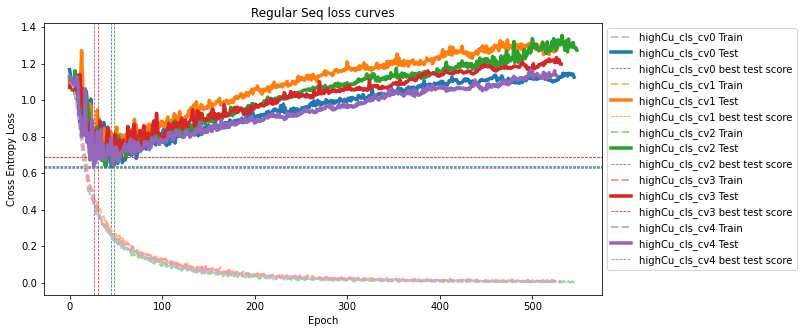

<Figure size 432x288 with 0 Axes>

In [44]:
tu.quick_loss_plot(
    [model_res[x]['data_label'][0] for x in model_res if "shuffle" not in x],
    title="Regular Seq loss curves",
    loss_str = "Cross Entropy Loss",
    save_file = 'out_coldStart_highCu_cls/regular_seq_loss_plot.png'
)

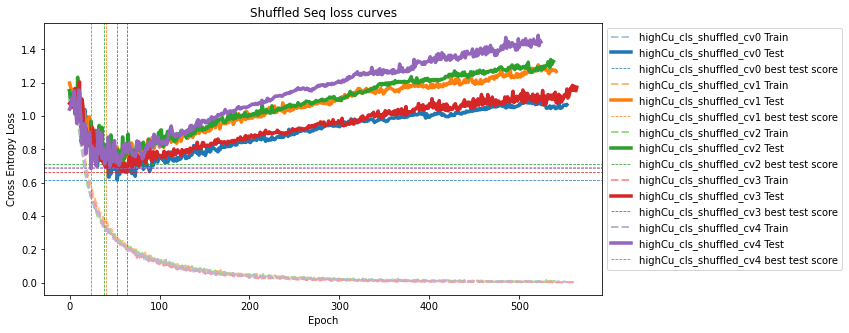

<Figure size 432x288 with 0 Axes>

In [45]:
tu.quick_loss_plot(
    [model_res[x]['data_label'][0] for x in model_res if "shuffle" in x],
    title="Shuffled Seq loss curves",
    loss_str = "Cross Entropy Loss",
    save_file = 'out_coldStart_highCu_cls/shuffled_seq_loss_plot.png'
)

### Save cold start pred df

In [48]:
#all_preds['task'] = 'highCu_cls'

In [49]:
all_preds.to_csv('out_coldStart_highCu_cls/all_pred_res.tsv',sep='\t',index=False)

## Run cold start regression task

In [51]:
model_res_regr = {}
pred_dfs_regr = {}

### Cold start regression for regular sequences

___Running CV0___


E:237 | train loss:2.181 | val loss: 4.616:   5%|▍         | 237/5000 [00:19<06:21, 12.49it/s]

EarlyStopping counter: 125 out of 500


E:362 | train loss:1.530 | val loss: 4.793:   7%|▋         | 363/5000 [00:29<06:11, 12.48it/s]

EarlyStopping counter: 250 out of 500


E:487 | train loss:1.210 | val loss: 4.957:  10%|▉         | 487/5000 [00:39<05:56, 12.65it/s]

EarlyStopping counter: 375 out of 500


E:610 | train loss:0.954 | val loss: 4.822:  12%|█▏        | 610/5000 [00:48<05:52, 12.46it/s]


EarlyStopping counter: 500 out of 500
Early stopping


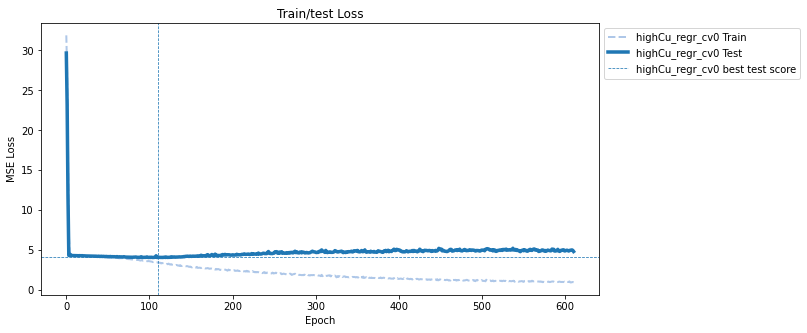

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:944: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


Predicting for highCu_regr_cv0
test split
Predicting for highCu_regr_cv0


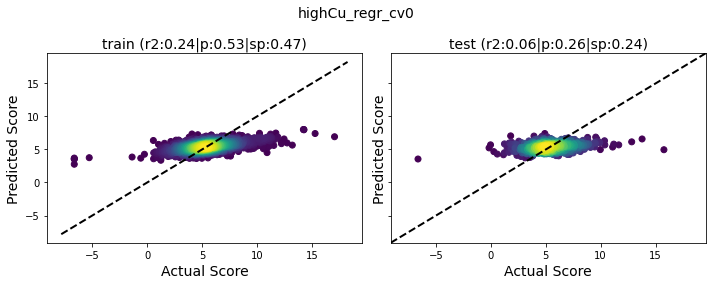

___Running CV1___


E:214 | train loss:2.387 | val loss: 4.702:   4%|▍         | 214/5000 [00:17<06:18, 12.63it/s]

EarlyStopping counter: 125 out of 500


E:339 | train loss:1.675 | val loss: 5.019:   7%|▋         | 340/5000 [00:27<06:11, 12.56it/s]

EarlyStopping counter: 250 out of 500


E:464 | train loss:1.205 | val loss: 5.223:   9%|▉         | 464/5000 [00:37<05:59, 12.61it/s]

EarlyStopping counter: 375 out of 500


E:587 | train loss:0.903 | val loss: 5.186:  12%|█▏        | 587/5000 [00:46<05:52, 12.51it/s]


EarlyStopping counter: 500 out of 500
Early stopping


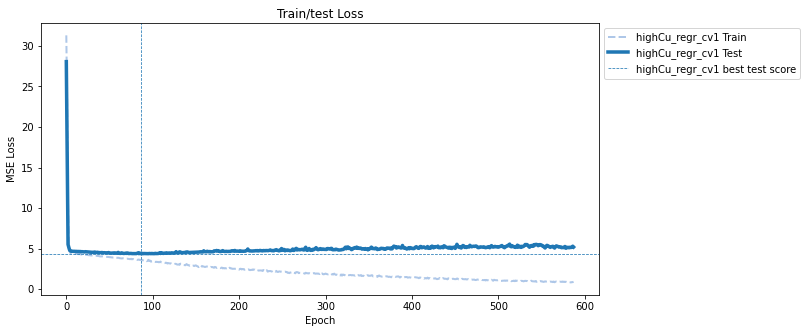

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:944: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


Predicting for highCu_regr_cv1
test split
Predicting for highCu_regr_cv1


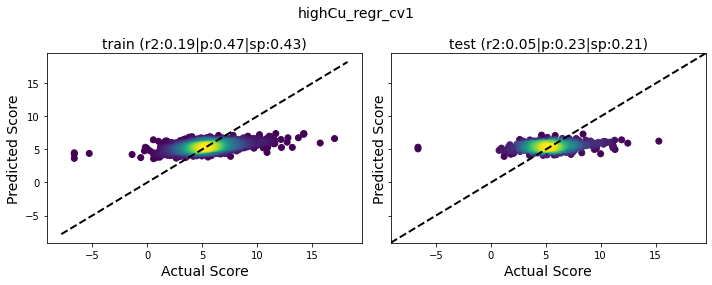

___Running CV2___


E:232 | train loss:2.641 | val loss: 3.854:   5%|▍         | 232/5000 [00:18<06:16, 12.66it/s]

EarlyStopping counter: 125 out of 500


E:357 | train loss:1.836 | val loss: 4.030:   7%|▋         | 358/5000 [00:28<06:09, 12.56it/s]

EarlyStopping counter: 250 out of 500


E:482 | train loss:1.365 | val loss: 4.256:  10%|▉         | 482/5000 [00:38<05:59, 12.58it/s]

EarlyStopping counter: 375 out of 500


E:605 | train loss:1.006 | val loss: 4.346:  12%|█▏        | 605/5000 [00:48<05:50, 12.56it/s]


EarlyStopping counter: 500 out of 500
Early stopping


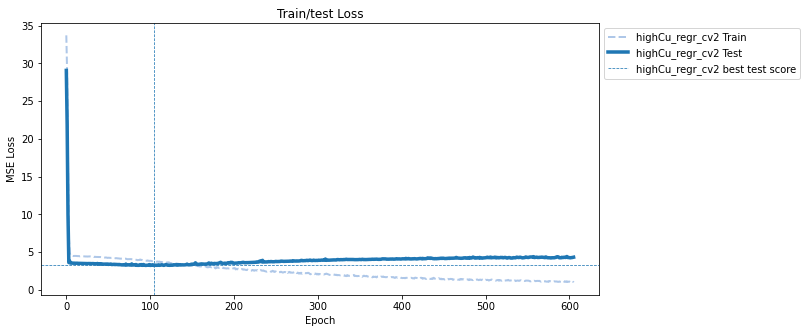

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:944: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


Predicting for highCu_regr_cv2
test split
Predicting for highCu_regr_cv2


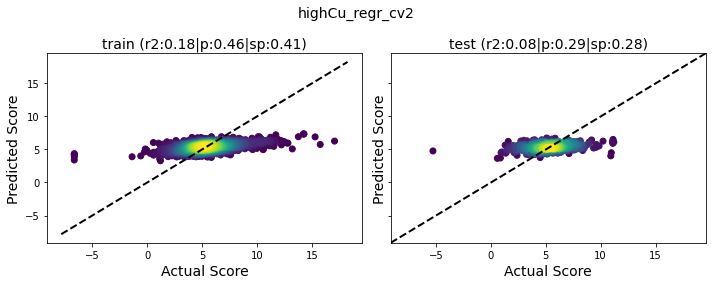

___Running CV3___


E:229 | train loss:2.357 | val loss: 4.790:   5%|▍         | 230/5000 [00:18<06:17, 12.63it/s]

EarlyStopping counter: 125 out of 500


E:354 | train loss:1.499 | val loss: 4.928:   7%|▋         | 354/5000 [00:28<06:07, 12.64it/s]

EarlyStopping counter: 250 out of 500


E:479 | train loss:1.188 | val loss: 5.053:  10%|▉         | 480/5000 [00:38<05:58, 12.62it/s]

EarlyStopping counter: 375 out of 500


E:602 | train loss:0.862 | val loss: 5.239:  12%|█▏        | 602/5000 [00:47<05:49, 12.58it/s]


EarlyStopping counter: 500 out of 500
Early stopping


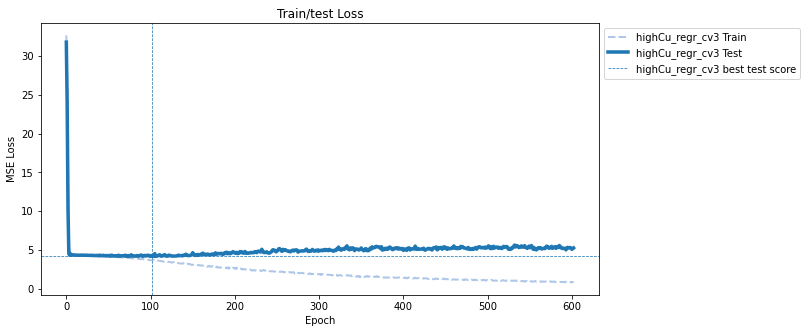

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:944: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


Predicting for highCu_regr_cv3
test split
Predicting for highCu_regr_cv3


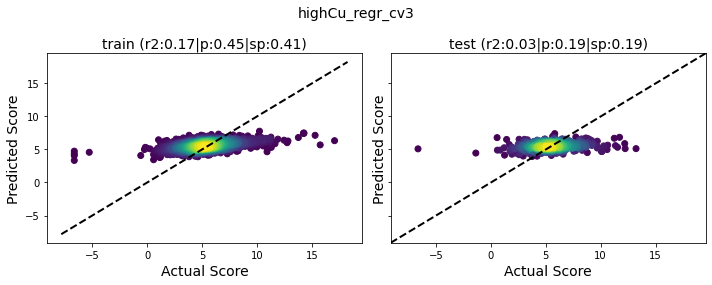

___Running CV4___


E:219 | train loss:2.520 | val loss: 5.121:   4%|▍         | 220/5000 [00:17<06:22, 12.50it/s]

EarlyStopping counter: 125 out of 500


E:344 | train loss:1.722 | val loss: 5.320:   7%|▋         | 344/5000 [00:27<06:10, 12.57it/s]

EarlyStopping counter: 250 out of 500


E:469 | train loss:1.194 | val loss: 5.631:   9%|▉         | 470/5000 [00:37<05:57, 12.67it/s]

EarlyStopping counter: 375 out of 500


E:592 | train loss:0.990 | val loss: 5.753:  12%|█▏        | 592/5000 [00:47<05:52, 12.50it/s]


EarlyStopping counter: 500 out of 500
Early stopping


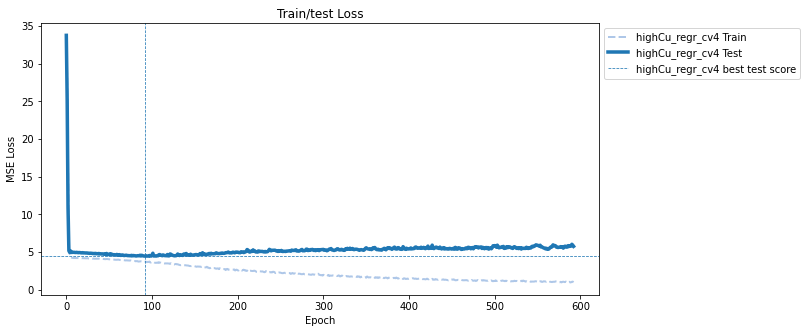

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:944: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


Predicting for highCu_regr_cv4
test split
Predicting for highCu_regr_cv4


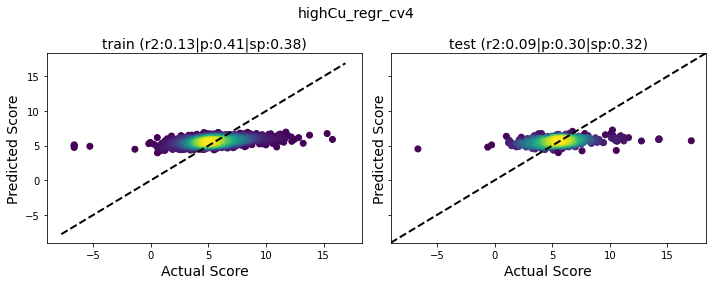

In [52]:
target_col = 'highCu'
seq_col = 'upstream_region'
locus_col = 'locus_tag'

# for each cv
for i in [0,1,2,3,4]:
    print(f"___Running CV{i}___")
    train_df = pd.read_csv(f'data/highCu_logTPM_reg_splits/cv{i}_train.tsv',sep='\t')
    test_df = pd.read_csv(f'data/highCu_logTPM_reg_splits/cv{i}_test.tsv',sep='\t')
    seq_len = len(train_df[seq_col].values[0])
    
    # sequences to predict on after training
    split_dfs = {
        'train':train_df,
        'test':test_df
    }

    # create data loaders
    dataset_types = [
        DatasetSpec('ohe'),
    ]

    dls = tu.build_dataloaders(
                    train_df, 
                    test_df, 
                    dataset_types, # just OHE for now
                    seq_col=seq_col,
                    target_col=target_col,
                )
    ohe_train_dl,ohe_val_dl = dls['ohe']
    
    m_args = (seq_len,1) # single task - regression
    m_kwargs = {
        "num_filters1":32,
        "num_filters2":32,
        "kernel_size1":10,
        "kernel_size2":6,
        "conv_pool_size1":2,
        "fc_node_num1":50,
        "fc_node_num2":50,
        "dropout1":0.25
    }
    
    model = m.DNA_2CNN_2FC(*m_args,**m_kwargs)
    model_name = f"highCu_regr_cv{i}"

    # +-------------+
    # | TRAIN MODEL |
    # +-------------+
    t_res = tu.collect_model_stats(
        model_name,
        seq_len,
        ohe_train_dl,
        ohe_val_dl,
        DEVICE,
        lr=0.0001,
        ep=5000,
        pat=500,
        opt=torch.optim.Adam,
        model=model,
        loss_type='regression'
    )
#     tu.quick_loss_plot(
#         t_res['data_label'],
#         title=f"{model_name} Loss Curve",
#         #save_file=f"{out_dir}/{model_name}_loss_plot.png"
#     )
    model_res_regr[model_name] = t_res
    
    # +------------+
    # | EVAL MODEL |
    # +------------+
    p_res_df = tu.parity_pred_by_split(
        model,
        model_name,
        DEVICE,
        split_dfs,
        locus_col=locus_col,
        seq_col=seq_col,
        target_col=target_col,
        splits=['train','test'],
        #save_file=f"{out_dir}/{model_name}_parity_plot.png"
    )
    p_res_df['model_type'] = "CNN"
    p_res_df['seq_mode'] = "regular"
    p_res_df['task'] = 'highCu_logTPM_regr'
    p_res_df['fold'] = i # which cv split
    p_res_df['best_val_score'] = t_res['best_val_score']
    p_res_df['epoch_stop'] = t_res['epoch_stop']
    p_res_df['total_time'] = t_res['total_time']
    
    pred_dfs_regr[model_name] = p_res_df
    
    
    
    

### Cold start for shuffled sequences

___Running CV0___


E:209 | train loss:2.939 | val loss: 4.793:   4%|▍         | 209/5000 [00:16<06:14, 12.81it/s]

EarlyStopping counter: 125 out of 500


E:334 | train loss:2.054 | val loss: 5.544:   7%|▋         | 335/5000 [00:26<06:09, 12.61it/s]

EarlyStopping counter: 250 out of 500


E:459 | train loss:1.490 | val loss: 5.782:   9%|▉         | 459/5000 [00:36<05:58, 12.65it/s]

EarlyStopping counter: 375 out of 500


E:582 | train loss:1.160 | val loss: 5.935:  12%|█▏        | 582/5000 [00:46<05:50, 12.61it/s]


EarlyStopping counter: 500 out of 500
Early stopping


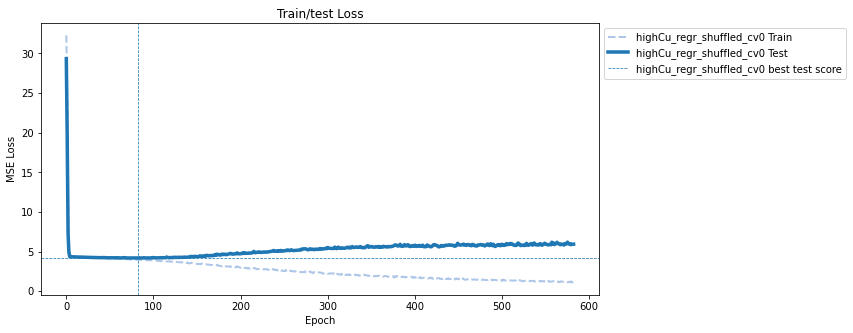

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:944: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


Predicting for highCu_regr_shuffled_cv0
test split
Predicting for highCu_regr_shuffled_cv0


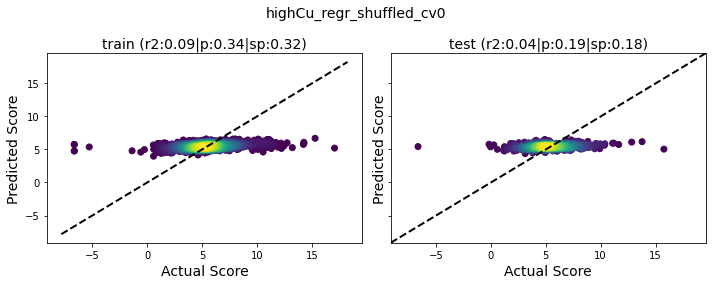

___Running CV1___


E:177 | train loss:3.137 | val loss: 4.861:   4%|▎         | 178/5000 [00:14<06:24, 12.55it/s]

EarlyStopping counter: 125 out of 500


E:302 | train loss:2.251 | val loss: 5.388:   6%|▌         | 302/5000 [00:24<06:16, 12.47it/s]

EarlyStopping counter: 250 out of 500


E:427 | train loss:1.574 | val loss: 5.599:   9%|▊         | 428/5000 [00:34<06:08, 12.41it/s]

EarlyStopping counter: 375 out of 500


E:550 | train loss:1.334 | val loss: 5.719:  11%|█         | 550/5000 [00:44<05:58, 12.43it/s]


EarlyStopping counter: 500 out of 500
Early stopping


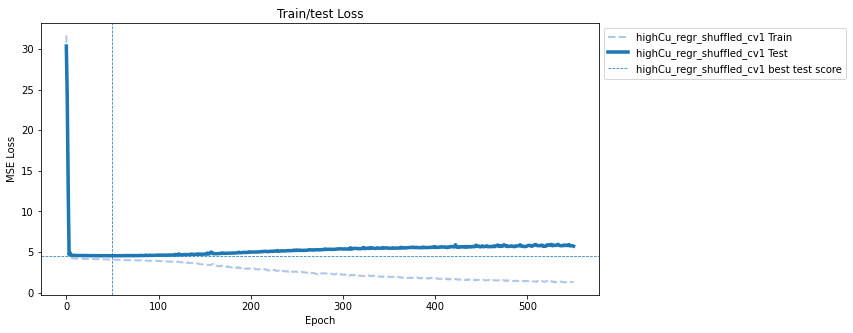

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:944: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


Predicting for highCu_regr_shuffled_cv1
test split
Predicting for highCu_regr_shuffled_cv1


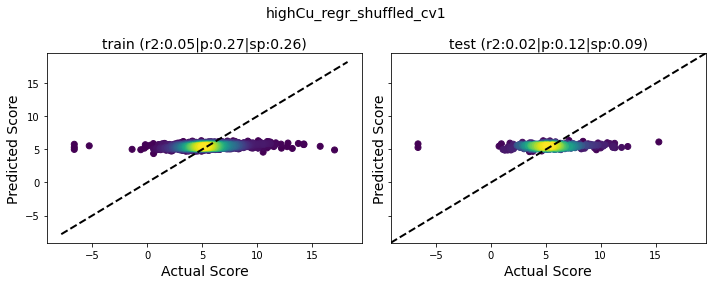

___Running CV2___


E:211 | train loss:3.221 | val loss: 3.877:   4%|▍         | 211/5000 [00:17<06:27, 12.37it/s]

EarlyStopping counter: 125 out of 500


E:336 | train loss:2.346 | val loss: 4.470:   7%|▋         | 337/5000 [00:27<06:12, 12.51it/s]

EarlyStopping counter: 250 out of 500


E:461 | train loss:1.825 | val loss: 4.777:   9%|▉         | 461/5000 [00:37<06:07, 12.36it/s]

EarlyStopping counter: 375 out of 500


E:584 | train loss:1.491 | val loss: 4.857:  12%|█▏        | 584/5000 [00:47<05:59, 12.27it/s]


EarlyStopping counter: 500 out of 500
Early stopping


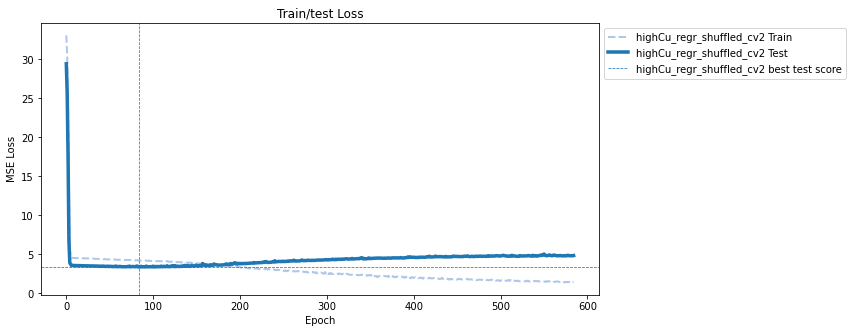

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:944: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


Predicting for highCu_regr_shuffled_cv2
test split
Predicting for highCu_regr_shuffled_cv2


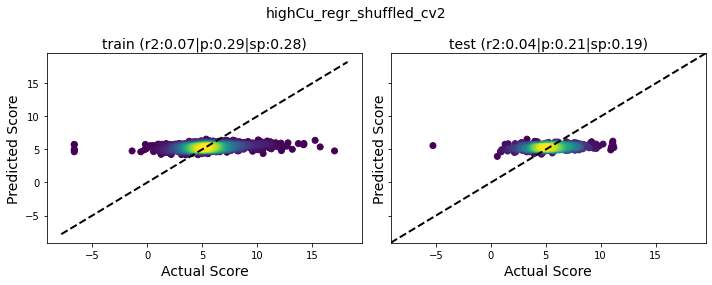

___Running CV3___


E:203 | train loss:3.118 | val loss: 4.613:   4%|▍         | 204/5000 [00:16<06:21, 12.59it/s]

EarlyStopping counter: 125 out of 500


E:328 | train loss:2.358 | val loss: 5.121:   7%|▋         | 328/5000 [00:26<06:12, 12.53it/s]

EarlyStopping counter: 250 out of 500


E:453 | train loss:1.624 | val loss: 5.531:   9%|▉         | 454/5000 [00:36<06:19, 11.96it/s]

EarlyStopping counter: 375 out of 500


E:576 | train loss:1.299 | val loss: 5.612:  12%|█▏        | 576/5000 [00:46<05:58, 12.33it/s]


EarlyStopping counter: 500 out of 500
Early stopping


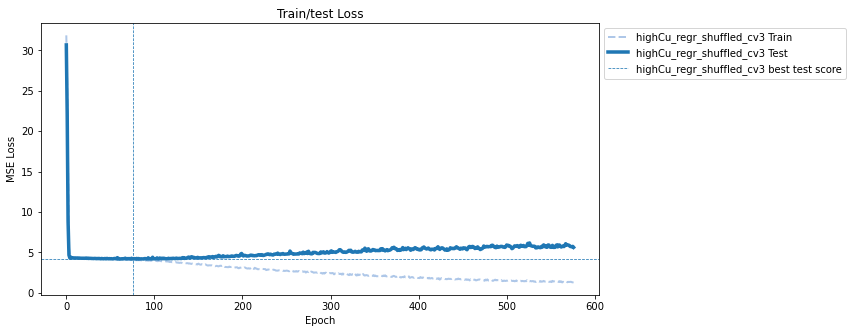

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:944: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


Predicting for highCu_regr_shuffled_cv3
test split
Predicting for highCu_regr_shuffled_cv3


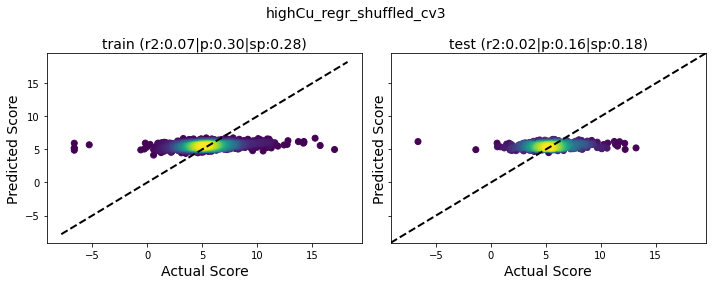

___Running CV4___


E:253 | train loss:2.492 | val loss: 5.375:   5%|▌         | 254/5000 [00:20<06:19, 12.51it/s]

EarlyStopping counter: 125 out of 500


E:378 | train loss:1.778 | val loss: 5.860:   8%|▊         | 378/5000 [00:30<06:09, 12.52it/s]

EarlyStopping counter: 250 out of 500


E:503 | train loss:1.378 | val loss: 6.058:  10%|█         | 504/5000 [00:40<06:04, 12.33it/s]

EarlyStopping counter: 375 out of 500


E:626 | train loss:1.044 | val loss: 6.386:  13%|█▎        | 626/5000 [00:50<05:52, 12.41it/s]


EarlyStopping counter: 500 out of 500
Early stopping


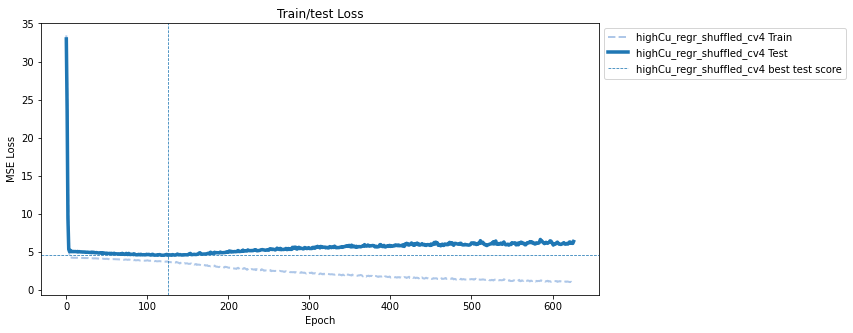

train split


/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['truth'] = df[target_col]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:944: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_df['pred'] = [x[0] for x in preds]
/home/ubuntu/workspace/mbur-sequence-learning/torch_utils.py:936: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


Predicting for highCu_regr_shuffled_cv4
test split
Predicting for highCu_regr_shuffled_cv4


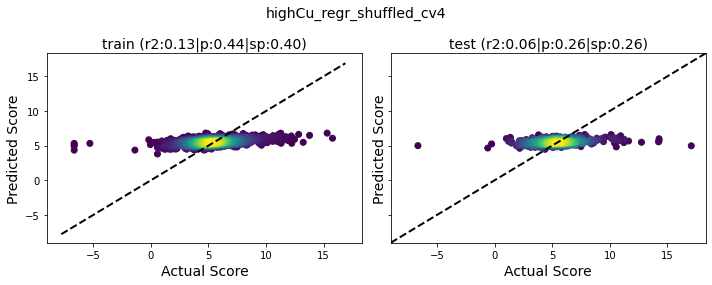

In [53]:
target_col = 'highCu'
seq_col = 'shuffled_seq'
locus_col = 'locus_tag'

# for each cv
for i in [0,1,2,3,4]:
    print(f"___Running CV{i}___")
    train_df = pd.read_csv(f'data/highCu_logTPM_reg_splits/cv{i}_train.tsv',sep='\t')
    test_df = pd.read_csv(f'data/highCu_logTPM_reg_splits/cv{i}_test.tsv',sep='\t')
    seq_len = len(train_df[seq_col].values[0])
    
    # sequences to predict on after training
    split_dfs = {
        'train':train_df,
        'test':test_df
    }

    # create data loaders
    dataset_types = [
        DatasetSpec('ohe'),
    ]

    dls = tu.build_dataloaders(
                    train_df, 
                    test_df, 
                    dataset_types, # just OHE for now
                    seq_col=seq_col,
                    target_col=target_col,
                )
    ohe_train_dl,ohe_val_dl = dls['ohe']
    
    m_args = (seq_len,1) # single task - regression
    m_kwargs = {
        "num_filters1":32,
        "num_filters2":32,
        "kernel_size1":10,
        "kernel_size2":6,
        "conv_pool_size1":2,
        "fc_node_num1":50,
        "fc_node_num2":50,
        "dropout1":0.25
    }
    
    model = m.DNA_2CNN_2FC(*m_args,**m_kwargs)
    model_name = f"highCu_regr_shuffled_cv{i}"

    # +-------------+
    # | TRAIN MODEL |
    # +-------------+
    t_res = tu.collect_model_stats(
        model_name,
        seq_len,
        ohe_train_dl,
        ohe_val_dl,
        DEVICE,
        lr=0.0001,
        ep=5000,
        pat=500,
        opt=torch.optim.Adam,
        model=model,
        loss_type='regression'
    )
#     tu.quick_loss_plot(
#         t_res['data_label'],
#         title=f"{model_name} Loss Curve",
#         #save_file=f"{out_dir}/{model_name}_loss_plot.png"
#     )
    model_res_regr[model_name] = t_res
    
    # +------------+
    # | EVAL MODEL |
    # +------------+
    p_res_df = tu.parity_pred_by_split(
        model,
        model_name,
        DEVICE,
        split_dfs,
        locus_col=locus_col,
        seq_col=seq_col,
        target_col=target_col,
        splits=['train','test'],
        #save_file=f"{out_dir}/{model_name}_parity_plot.png"
    )
    p_res_df['model_type'] = "CNN"
    p_res_df['seq_mode'] = "shuffled"
    p_res_df['task'] = 'highCu_logTPM_regr'
    p_res_df['fold'] = i # which cv split
    p_res_df['best_val_score'] = t_res['best_val_score']
    p_res_df['epoch_stop'] = t_res['epoch_stop']
    p_res_df['total_time'] = t_res['total_time']
    
    pred_dfs_regr[model_name] = p_res_df
    
    
    
    

## Compare overall predictions

In [54]:
all_preds_regr = pd.concat([pred_dfs_regr[x] for x in pred_dfs_regr])
all_preds_regr

,model_name,split,r2,pearson,spearman,model_type,seq_mode,task,fold,best_val_score,epoch_stop,total_time
0,highCu_regr_cv0,train,0.237704,0.526594,0.468500,CNN,regular,highCu_logTPM_regr,0,4.071888,110,48.971549
1,highCu_regr_cv0,test,0.063358,0.259044,0.238527,CNN,regular,highCu_logTPM_regr,0,4.071888,110,48.971549
0,highCu_regr_cv1,train,0.186872,0.467538,0.427985,CNN,regular,highCu_logTPM_regr,1,4.366968,87,46.944551
1,highCu_regr_cv1,test,0.052716,0.230661,0.210085,CNN,regular,highCu_logTPM_regr,1,4.366968,87,46.944551
0,highCu_regr_cv2,train,0.177735,0.464912,0.411180,CNN,regular,highCu_logTPM_regr,2,3.258085,105,48.191302
1,highCu_regr_cv2,test,0.084513,0.292387,0.282982,CNN,regular,highCu_logTPM_regr,2,3.258085,105,48.191302
0,highCu_regr_cv3,train,0.173613,0.447651,0.409767,CNN,regular,highCu_logTPM_regr,3,4.155636,102,47.862028
1,highCu_regr_cv3,test,0.026515,0.187466,0.186481,CNN,regular,highCu_logTPM_regr,3,4.155636,102,47.862028
0,highCu_regr_cv4,train,0.128434,0.409302,0.384180,CNN,regular,highCu_logTPM_regr,4,4.455547,92,47.352583
1,highCu_regr_cv4,test,0.085216,0.303782,0.316751,CNN,regular,highCu_logTPM_regr,4,4.455547,92,47.352583


In [55]:
def plot_metric(df,metric):
    sns.barplot(data=df,y='model_name',x=metric,hue='split',dodge=True)
    plt.legend(bbox_to_anchor=(1,1),loc='upper left')
    plt.xlabel(f"{metric} score",fontsize=14)
    plt.xticks(fontsize=14)
    plt.ylabel("")
    plt.yticks(fontsize=14)
    plt.show()

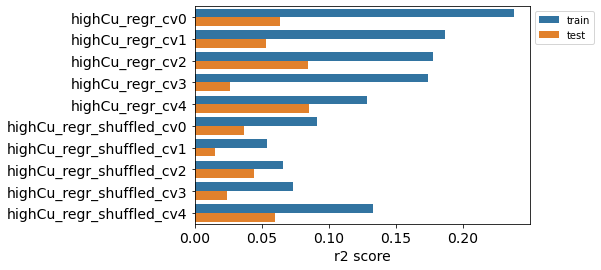

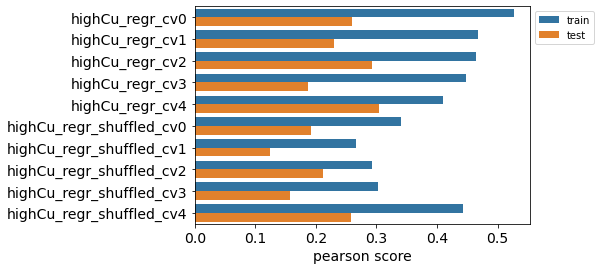

In [56]:
plot_metric(all_preds_regr,'r2')
plot_metric(all_preds_regr,'pearson')

Note: the TRAIN SET performance scores seem much better in the regular than in the shuffled sequences - does that mean anything?

In [74]:
df_train = all_preds_regr[all_preds_regr['split']=='train']
df_test = all_preds_regr[all_preds_regr['split']=='test']

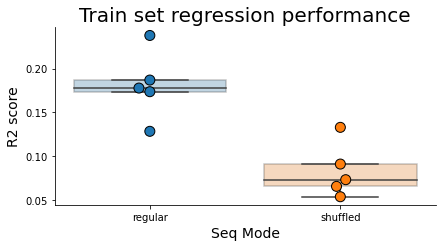

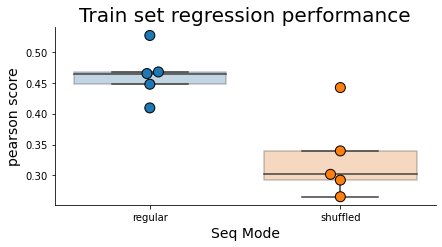

In [68]:
# TRAIN
g = sns.catplot(
    data=df_train, x='seq_mode', y='r2',
    kind='box',
    boxprops=dict(alpha=.3),height=3,aspect=4/2
)
g.map_dataframe(sns.swarmplot, 
                x='seq_mode', y='r2',
                size=10, edgecolor='black',linewidth=1, dodge=True,palette='tab10')

for ax in g.axes.flatten():
    #ax.set_xlabel('Dataset size', fontsize=14)
    ax.set_ylabel('R2 score', fontsize=14)
plt.xlabel("Seq Mode",fontsize=14)
plt.title("Train set regression performance",fontsize=20)
plt.show()

g = sns.catplot(
    data=df_train, x='seq_mode', y='pearson',
    kind='box',
    boxprops=dict(alpha=.3),height=3,aspect=4/2
)
g.map_dataframe(sns.swarmplot, 
                x='seq_mode', y='pearson',
                size=10, edgecolor='black',linewidth=1, dodge=True,palette='tab10')

for ax in g.axes.flatten():
    #ax.set_xlabel('Dataset size', fontsize=14)
    ax.set_ylabel('pearson score', fontsize=14)
plt.xlabel("Seq Mode",fontsize=14)
plt.title("Train set regression performance",fontsize=20)
plt.show()

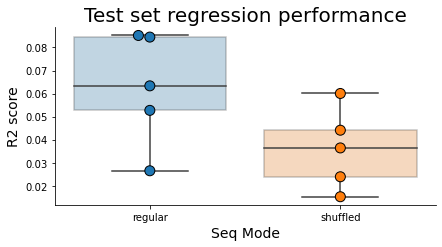

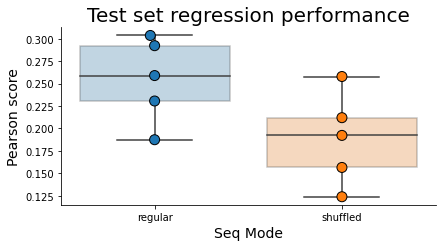

In [69]:
g = sns.catplot(
    data=df_test, x='seq_mode', y='r2',
    kind='box',
    boxprops=dict(alpha=.3),height=3,aspect=4/2
)
g.map_dataframe(sns.swarmplot, 
                x='seq_mode', y='r2',
                size=10, edgecolor='black',linewidth=1, dodge=True,palette='tab10')

for ax in g.axes.flatten():
    #ax.set_xlabel('Dataset size', fontsize=14)
    ax.set_ylabel('R2 score', fontsize=14)
plt.xlabel("Seq Mode",fontsize=14)
plt.title("Test set regression performance",fontsize=20)
plt.show()

g = sns.catplot(
    data=df_test, x='seq_mode', y='pearson',
    kind='box',
    boxprops=dict(alpha=.3),height=3,aspect=4/2
)
g.map_dataframe(sns.swarmplot, 
                x='seq_mode', y='pearson',
                size=10, edgecolor='black',linewidth=1, dodge=True,palette='tab10')

for ax in g.axes.flatten():
    #ax.set_xlabel('Dataset size', fontsize=14)
    ax.set_ylabel('Pearson score', fontsize=14)
plt.xlabel("Seq Mode",fontsize=14)
plt.title("Test set regression performance",fontsize=20)
plt.show()

Statistical difference in test set means?

In [77]:
regular_r2scores = df_test[df_test['seq_mode']=='regular']['r2'].values
shuffled_r2scores = df_test[df_test['seq_mode']=='shuffled']['r2'].values
print("R2")
print(ttest_ind(regular_r2scores, shuffled_r2scores))

regular_pearsonscores = df_test[df_test['seq_mode']=='regular']['pearson'].values
shuffled_pearsonscores = df_test[df_test['seq_mode']=='shuffled']['pearson'].values
print("Pearson")
print(ttest_ind(regular_pearsonscores, shuffled_pearsonscores))

R2
Ttest_indResult(statistic=1.9726930884402598, pvalue=0.08399300817639718)
Pearson
Ttest_indResult(statistic=2.1152950391989545, pvalue=0.06731633505978318)


In [78]:
print("Mean R2 for regular seqs:",np.mean(regular_r2scores))
print("Mean R2 for shuffled seqs:",np.mean(shuffled_r2scores))
print()
print("Mean Pearson for regular seqs:",np.mean(regular_pearsonscores))
print("Mean Pearson for shuffled seqs:",np.mean(shuffled_pearsonscores))

Mean R2 for regular seqs: 0.06246340428375401
Mean R2 for shuffled seqs: 0.03594895300093193

Mean Pearson for regular seqs: 0.2546681433317035
Mean Pearson for shuffled seqs: 0.18853952268728058


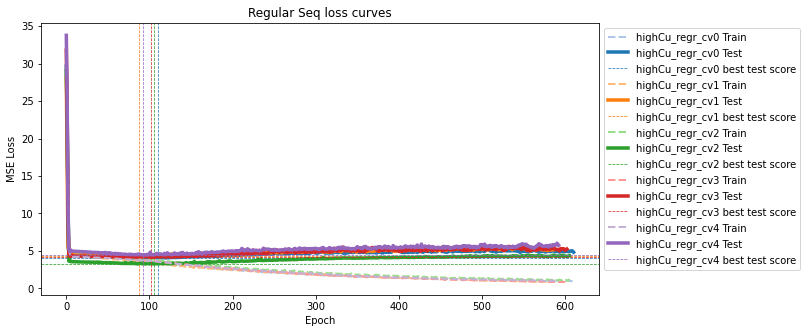

<Figure size 432x288 with 0 Axes>

In [64]:
tu.quick_loss_plot(
    [model_res_regr[x]['data_label'][0] for x in model_res_regr if "shuffle" not in x],
    title="Regular Seq loss curves",
    loss_str = "MSE Loss",
    save_file = 'out_coldStart_highCu_regr/regular_seq_loss_plot.png'
)

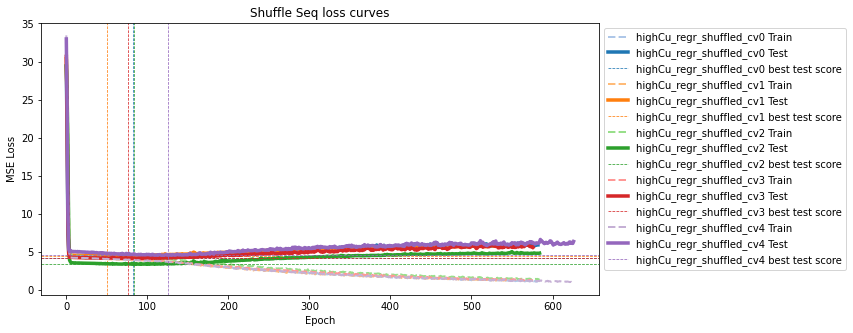

<Figure size 432x288 with 0 Axes>

In [65]:
tu.quick_loss_plot(
    [model_res_regr[x]['data_label'][0] for x in model_res_regr if "shuffle" in x],
    title="Shuffle Seq loss curves",
    loss_str = "MSE Loss",
    save_file = 'out_coldStart_highCu_regr/shuffle_seq_loss_plot.png'
)

In [79]:
all_preds_regr.to_csv('out_coldStart_highCu_regr/all_pred_res.tsv',sep='\t',index=False)